In [98]:
from libraries import * 
from preprocessing import downloading_loading_processed_files
from utils import enframe
import torchvision.transforms as T
warnings.filterwarnings("ignore")

# selecting GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on GPU = {str(device) == 'cuda'}")

# (down)loading split datasets, can be run twice if kernel dies 1st time
train_set, validation_set, test_set = downloading_loading_processed_files(
    downsampling=False)
print(f"loading of datasets done")

# setting up computational parameters
if device == "cuda":
    num_workers, pin_memory = 4, True
else:
    num_workers, pin_memory = 0, False

running on GPU = False
loading of datasets done


In [99]:
# all element in dataset are shpae 78*13
# about 2,8 to 2,9% of the inputs have nan in it (preprocessing problematic: dataset should be filtered
def remove_nan_in(dataset):
    not_nan_entries = []
    for i, (lmfcc, sample_rate, label, speaker_id, utterance_number) in enumerate(dataset):
        if not np.isnan(lmfcc).any():
            not_nan_entries.append(i)
    return np.array(dataset)[not_nan_entries]

train_set = remove_nan_in(train_set)
validation_set = remove_nan_in(validation_set)

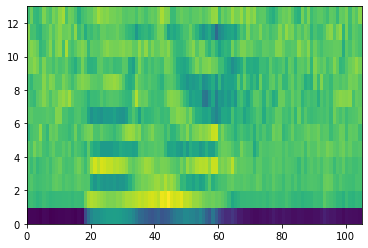

In [100]:
plt.pcolormesh(train_set[10][0].T);

In [114]:
for i,train in enumerate(train_set):
    print(i, train[0].shape)

0 (105, 13)
1 (105, 13)
2 (105, 13)
3 (105, 13)
4 (105, 13)
5 (105, 13)
6 (105, 13)
7 (105, 13)
8 (105, 13)
9 (105, 13)
10 (105, 13)
11 (105, 13)
12 (105, 13)
13 (105, 13)
14 (105, 13)
15 (105, 13)
16 (105, 13)
17 (105, 13)
18 (105, 13)
19 (105, 13)
20 (105, 13)
21 (105, 13)
22 (105, 13)
23 (105, 13)
24 (105, 13)
25 (105, 13)
26 (105, 13)
27 (105, 13)
28 (105, 13)
29 (105, 13)
30 (105, 13)
31 (105, 13)
32 (105, 13)
33 (105, 13)
34 (105, 13)
35 (71, 13)
36 (105, 13)
37 (105, 13)
38 (105, 13)
39 (105, 13)
40 (105, 13)
41 (105, 13)
42 (105, 13)
43 (105, 13)
44 (105, 13)
45 (105, 13)
46 (105, 13)
47 (105, 13)
48 (105, 13)
49 (105, 13)
50 (105, 13)
51 (73, 13)
52 (105, 13)
53 (105, 13)
54 (105, 13)
55 (105, 13)
56 (105, 13)
57 (105, 13)
58 (105, 13)
59 (105, 13)
60 (105, 13)
61 (90, 13)
62 (105, 13)
63 (105, 13)
64 (105, 13)
65 (105, 13)
66 (105, 13)
67 (105, 13)
68 (105, 13)
69 (105, 13)
70 (105, 13)
71 (105, 13)
72 (105, 13)
73 (105, 13)
74 (105, 13)
75 (105, 13)
76 (105, 13)
77 (105, 13)

852 (71, 13)
853 (73, 13)
854 (105, 13)
855 (105, 13)
856 (105, 13)
857 (105, 13)
858 (105, 13)
859 (105, 13)
860 (105, 13)
861 (105, 13)
862 (105, 13)
863 (105, 13)
864 (105, 13)
865 (105, 13)
866 (105, 13)
867 (105, 13)
868 (105, 13)
869 (105, 13)
870 (105, 13)
871 (105, 13)
872 (105, 13)
873 (105, 13)
874 (105, 13)
875 (105, 13)
876 (105, 13)
877 (105, 13)
878 (105, 13)
879 (105, 13)
880 (105, 13)
881 (105, 13)
882 (105, 13)
883 (105, 13)
884 (105, 13)
885 (105, 13)
886 (105, 13)
887 (105, 13)
888 (105, 13)
889 (105, 13)
890 (105, 13)
891 (105, 13)
892 (105, 13)
893 (105, 13)
894 (105, 13)
895 (105, 13)
896 (105, 13)
897 (105, 13)
898 (105, 13)
899 (105, 13)
900 (105, 13)
901 (105, 13)
902 (105, 13)
903 (105, 13)
904 (105, 13)
905 (80, 13)
906 (105, 13)
907 (105, 13)
908 (105, 13)
909 (105, 13)
910 (105, 13)
911 (105, 13)
912 (105, 13)
913 (105, 13)
914 (105, 13)
915 (105, 13)
916 (105, 13)
917 (105, 13)
918 (105, 13)
919 (105, 13)
920 (105, 13)
921 (105, 13)
922 (105, 13)
923 (105,

1602 (105, 13)
1603 (105, 13)
1604 (105, 13)
1605 (105, 13)
1606 (105, 13)
1607 (58, 13)
1608 (67, 13)
1609 (105, 13)
1610 (105, 13)
1611 (105, 13)
1612 (105, 13)
1613 (105, 13)
1614 (105, 13)
1615 (105, 13)
1616 (105, 13)
1617 (105, 13)
1618 (105, 13)
1619 (105, 13)
1620 (105, 13)
1621 (105, 13)
1622 (105, 13)
1623 (105, 13)
1624 (105, 13)
1625 (105, 13)
1626 (105, 13)
1627 (98, 13)
1628 (105, 13)
1629 (105, 13)
1630 (105, 13)
1631 (83, 13)
1632 (105, 13)
1633 (105, 13)
1634 (105, 13)
1635 (105, 13)
1636 (105, 13)
1637 (105, 13)
1638 (105, 13)
1639 (105, 13)
1640 (105, 13)
1641 (105, 13)
1642 (105, 13)
1643 (105, 13)
1644 (105, 13)
1645 (105, 13)
1646 (105, 13)
1647 (105, 13)
1648 (105, 13)
1649 (105, 13)
1650 (105, 13)
1651 (105, 13)
1652 (105, 13)
1653 (105, 13)
1654 (105, 13)
1655 (105, 13)
1656 (105, 13)
1657 (105, 13)
1658 (105, 13)
1659 (105, 13)
1660 (105, 13)
1661 (105, 13)
1662 (105, 13)
1663 (105, 13)
1664 (105, 13)
1665 (105, 13)
1666 (105, 13)
1667 (105, 13)
1668 (105, 13)

2352 (93, 13)
2353 (105, 13)
2354 (105, 13)
2355 (105, 13)
2356 (103, 13)
2357 (58, 13)
2358 (105, 13)
2359 (105, 13)
2360 (105, 13)
2361 (105, 13)
2362 (105, 13)
2363 (105, 13)
2364 (105, 13)
2365 (105, 13)
2366 (105, 13)
2367 (105, 13)
2368 (105, 13)
2369 (105, 13)
2370 (105, 13)
2371 (105, 13)
2372 (105, 13)
2373 (105, 13)
2374 (105, 13)
2375 (105, 13)
2376 (105, 13)
2377 (105, 13)
2378 (105, 13)
2379 (105, 13)
2380 (105, 13)
2381 (105, 13)
2382 (105, 13)
2383 (105, 13)
2384 (105, 13)
2385 (105, 13)
2386 (105, 13)
2387 (105, 13)
2388 (105, 13)
2389 (105, 13)
2390 (105, 13)
2391 (105, 13)
2392 (105, 13)
2393 (99, 13)
2394 (103, 13)
2395 (105, 13)
2396 (105, 13)
2397 (105, 13)
2398 (105, 13)
2399 (99, 13)
2400 (105, 13)
2401 (105, 13)
2402 (105, 13)
2403 (105, 13)
2404 (105, 13)
2405 (71, 13)
2406 (105, 13)
2407 (105, 13)
2408 (105, 13)
2409 (105, 13)
2410 (105, 13)
2411 (105, 13)
2412 (105, 13)
2413 (105, 13)
2414 (80, 13)
2415 (105, 13)
2416 (105, 13)
2417 (105, 13)
2418 (105, 13)
2

3102 (105, 13)
3103 (103, 13)
3104 (105, 13)
3105 (105, 13)
3106 (105, 13)
3107 (105, 13)
3108 (103, 13)
3109 (105, 13)
3110 (105, 13)
3111 (105, 13)
3112 (105, 13)
3113 (66, 13)
3114 (105, 13)
3115 (105, 13)
3116 (105, 13)
3117 (105, 13)
3118 (105, 13)
3119 (105, 13)
3120 (105, 13)
3121 (90, 13)
3122 (105, 13)
3123 (105, 13)
3124 (105, 13)
3125 (105, 13)
3126 (105, 13)
3127 (105, 13)
3128 (105, 13)
3129 (105, 13)
3130 (105, 13)
3131 (105, 13)
3132 (105, 13)
3133 (103, 13)
3134 (105, 13)
3135 (105, 13)
3136 (105, 13)
3137 (105, 13)
3138 (76, 13)
3139 (105, 13)
3140 (88, 13)
3141 (88, 13)
3142 (105, 13)
3143 (62, 13)
3144 (105, 13)
3145 (105, 13)
3146 (103, 13)
3147 (73, 13)
3148 (105, 13)
3149 (103, 13)
3150 (105, 13)
3151 (88, 13)
3152 (105, 13)
3153 (105, 13)
3154 (105, 13)
3155 (105, 13)
3156 (105, 13)
3157 (105, 13)
3158 (105, 13)
3159 (105, 13)
3160 (105, 13)
3161 (80, 13)
3162 (105, 13)
3163 (105, 13)
3164 (105, 13)
3165 (105, 13)
3166 (105, 13)
3167 (105, 13)
3168 (105, 13)
3169

3851 (105, 13)
3852 (105, 13)
3853 (68, 13)
3854 (105, 13)
3855 (105, 13)
3856 (105, 13)
3857 (105, 13)
3858 (105, 13)
3859 (105, 13)
3860 (105, 13)
3861 (105, 13)
3862 (105, 13)
3863 (105, 13)
3864 (33, 13)
3865 (105, 13)
3866 (105, 13)
3867 (105, 13)
3868 (105, 13)
3869 (105, 13)
3870 (105, 13)
3871 (105, 13)
3872 (105, 13)
3873 (105, 13)
3874 (105, 13)
3875 (105, 13)
3876 (105, 13)
3877 (105, 13)
3878 (105, 13)
3879 (105, 13)
3880 (105, 13)
3881 (105, 13)
3882 (105, 13)
3883 (105, 13)
3884 (105, 13)
3885 (105, 13)
3886 (105, 13)
3887 (90, 13)
3888 (105, 13)
3889 (98, 13)
3890 (105, 13)
3891 (103, 13)
3892 (105, 13)
3893 (105, 13)
3894 (105, 13)
3895 (105, 13)
3896 (105, 13)
3897 (105, 13)
3898 (105, 13)
3899 (105, 13)
3900 (105, 13)
3901 (105, 13)
3902 (105, 13)
3903 (105, 13)
3904 (105, 13)
3905 (105, 13)
3906 (105, 13)
3907 (78, 13)
3908 (88, 13)
3909 (105, 13)
3910 (105, 13)
3911 (105, 13)
3912 (105, 13)
3913 (105, 13)
3914 (105, 13)
3915 (49, 13)
3916 (76, 13)
3917 (105, 13)
391

4601 (105, 13)
4602 (105, 13)
4603 (105, 13)
4604 (105, 13)
4605 (105, 13)
4606 (105, 13)
4607 (105, 13)
4608 (90, 13)
4609 (58, 13)
4610 (105, 13)
4611 (105, 13)
4612 (105, 13)
4613 (105, 13)
4614 (105, 13)
4615 (105, 13)
4616 (105, 13)
4617 (105, 13)
4618 (105, 13)
4619 (105, 13)
4620 (105, 13)
4621 (105, 13)
4622 (103, 13)
4623 (105, 13)
4624 (105, 13)
4625 (105, 13)
4626 (103, 13)
4627 (105, 13)
4628 (99, 13)
4629 (105, 13)
4630 (105, 13)
4631 (105, 13)
4632 (105, 13)
4633 (103, 13)
4634 (103, 13)
4635 (105, 13)
4636 (88, 13)
4637 (105, 13)
4638 (105, 13)
4639 (105, 13)
4640 (105, 13)
4641 (105, 13)
4642 (105, 13)
4643 (105, 13)
4644 (105, 13)
4645 (105, 13)
4646 (105, 13)
4647 (105, 13)
4648 (105, 13)
4649 (105, 13)
4650 (98, 13)
4651 (88, 13)
4652 (105, 13)
4653 (93, 13)
4654 (105, 13)
4655 (105, 13)
4656 (105, 13)
4657 (105, 13)
4658 (105, 13)
4659 (105, 13)
4660 (105, 13)
4661 (105, 13)
4662 (105, 13)
4663 (105, 13)
4664 (98, 13)
4665 (105, 13)
4666 (105, 13)
4667 (105, 13)
466

5351 (105, 13)
5352 (105, 13)
5353 (105, 13)
5354 (105, 13)
5355 (105, 13)
5356 (105, 13)
5357 (105, 13)
5358 (98, 13)
5359 (105, 13)
5360 (94, 13)
5361 (105, 13)
5362 (105, 13)
5363 (105, 13)
5364 (105, 13)
5365 (105, 13)
5366 (105, 13)
5367 (85, 13)
5368 (93, 13)
5369 (105, 13)
5370 (105, 13)
5371 (105, 13)
5372 (105, 13)
5373 (105, 13)
5374 (105, 13)
5375 (105, 13)
5376 (105, 13)
5377 (105, 13)
5378 (105, 13)
5379 (105, 13)
5380 (105, 13)
5381 (105, 13)
5382 (105, 13)
5383 (105, 13)
5384 (80, 13)
5385 (90, 13)
5386 (105, 13)
5387 (105, 13)
5388 (105, 13)
5389 (79, 13)
5390 (105, 13)
5391 (105, 13)
5392 (105, 13)
5393 (67, 13)
5394 (105, 13)
5395 (105, 13)
5396 (105, 13)
5397 (105, 13)
5398 (105, 13)
5399 (105, 13)
5400 (105, 13)
5401 (105, 13)
5402 (105, 13)
5403 (105, 13)
5404 (105, 13)
5405 (105, 13)
5406 (105, 13)
5407 (105, 13)
5408 (105, 13)
5409 (90, 13)
5410 (105, 13)
5411 (105, 13)
5412 (105, 13)
5413 (105, 13)
5414 (105, 13)
5415 (105, 13)
5416 (103, 13)
5417 (105, 13)
5418

6101 (105, 13)
6102 (105, 13)
6103 (105, 13)
6104 (105, 13)
6105 (105, 13)
6106 (105, 13)
6107 (105, 13)
6108 (105, 13)
6109 (105, 13)
6110 (105, 13)
6111 (105, 13)
6112 (105, 13)
6113 (105, 13)
6114 (105, 13)
6115 (105, 13)
6116 (105, 13)
6117 (105, 13)
6118 (105, 13)
6119 (105, 13)
6120 (105, 13)
6121 (105, 13)
6122 (105, 13)
6123 (105, 13)
6124 (103, 13)
6125 (105, 13)
6126 (105, 13)
6127 (105, 13)
6128 (105, 13)
6129 (105, 13)
6130 (105, 13)
6131 (62, 13)
6132 (80, 13)
6133 (85, 13)
6134 (105, 13)
6135 (105, 13)
6136 (105, 13)
6137 (105, 13)
6138 (105, 13)
6139 (105, 13)
6140 (105, 13)
6141 (105, 13)
6142 (105, 13)
6143 (105, 13)
6144 (105, 13)
6145 (105, 13)
6146 (105, 13)
6147 (105, 13)
6148 (105, 13)
6149 (105, 13)
6150 (105, 13)
6151 (105, 13)
6152 (105, 13)
6153 (105, 13)
6154 (105, 13)
6155 (105, 13)
6156 (105, 13)
6157 (105, 13)
6158 (105, 13)
6159 (105, 13)
6160 (105, 13)
6161 (105, 13)
6162 (105, 13)
6163 (105, 13)
6164 (105, 13)
6165 (105, 13)
6166 (105, 13)
6167 (105, 13

7100 (105, 13)
7101 (105, 13)
7102 (105, 13)
7103 (105, 13)
7104 (105, 13)
7105 (105, 13)
7106 (105, 13)
7107 (105, 13)
7108 (105, 13)
7109 (105, 13)
7110 (105, 13)
7111 (105, 13)
7112 (105, 13)
7113 (105, 13)
7114 (105, 13)
7115 (105, 13)
7116 (105, 13)
7117 (105, 13)
7118 (105, 13)
7119 (105, 13)
7120 (105, 13)
7121 (105, 13)
7122 (105, 13)
7123 (105, 13)
7124 (105, 13)
7125 (105, 13)
7126 (105, 13)
7127 (105, 13)
7128 (105, 13)
7129 (105, 13)
7130 (105, 13)
7131 (105, 13)
7132 (105, 13)
7133 (105, 13)
7134 (105, 13)
7135 (105, 13)
7136 (85, 13)
7137 (105, 13)
7138 (105, 13)
7139 (103, 13)
7140 (105, 13)
7141 (105, 13)
7142 (105, 13)
7143 (105, 13)
7144 (105, 13)
7145 (105, 13)
7146 (105, 13)
7147 (105, 13)
7148 (105, 13)
7149 (105, 13)
7150 (105, 13)
7151 (105, 13)
7152 (105, 13)
7153 (105, 13)
7154 (105, 13)
7155 (105, 13)
7156 (105, 13)
7157 (105, 13)
7158 (105, 13)
7159 (105, 13)
7160 (105, 13)
7161 (105, 13)
7162 (105, 13)
7163 (105, 13)
7164 (105, 13)
7165 (105, 13)
7166 (105, 

7850 (105, 13)
7851 (105, 13)
7852 (105, 13)
7853 (105, 13)
7854 (105, 13)
7855 (105, 13)
7856 (105, 13)
7857 (105, 13)
7858 (105, 13)
7859 (105, 13)
7860 (105, 13)
7861 (105, 13)
7862 (105, 13)
7863 (105, 13)
7864 (105, 13)
7865 (105, 13)
7866 (90, 13)
7867 (103, 13)
7868 (105, 13)
7869 (80, 13)
7870 (105, 13)
7871 (105, 13)
7872 (105, 13)
7873 (105, 13)
7874 (105, 13)
7875 (105, 13)
7876 (105, 13)
7877 (105, 13)
7878 (105, 13)
7879 (105, 13)
7880 (105, 13)
7881 (105, 13)
7882 (105, 13)
7883 (105, 13)
7884 (105, 13)
7885 (105, 13)
7886 (71, 13)
7887 (94, 13)
7888 (105, 13)
7889 (105, 13)
7890 (105, 13)
7891 (105, 13)
7892 (105, 13)
7893 (105, 13)
7894 (105, 13)
7895 (105, 13)
7896 (105, 13)
7897 (105, 13)
7898 (105, 13)
7899 (105, 13)
7900 (105, 13)
7901 (105, 13)
7902 (105, 13)
7903 (105, 13)
7904 (105, 13)
7905 (105, 13)
7906 (105, 13)
7907 (105, 13)
7908 (105, 13)
7909 (105, 13)
7910 (105, 13)
7911 (105, 13)
7912 (105, 13)
7913 (105, 13)
7914 (105, 13)
7915 (105, 13)
7916 (105, 13)

8850 (105, 13)
8851 (105, 13)
8852 (105, 13)
8853 (105, 13)
8854 (105, 13)
8855 (105, 13)
8856 (105, 13)
8857 (105, 13)
8858 (105, 13)
8859 (105, 13)
8860 (105, 13)
8861 (105, 13)
8862 (105, 13)
8863 (105, 13)
8864 (105, 13)
8865 (105, 13)
8866 (105, 13)
8867 (105, 13)
8868 (105, 13)
8869 (105, 13)
8870 (105, 13)
8871 (105, 13)
8872 (105, 13)
8873 (105, 13)
8874 (105, 13)
8875 (105, 13)
8876 (105, 13)
8877 (105, 13)
8878 (105, 13)
8879 (105, 13)
8880 (105, 13)
8881 (105, 13)
8882 (105, 13)
8883 (105, 13)
8884 (105, 13)
8885 (105, 13)
8886 (105, 13)
8887 (105, 13)
8888 (105, 13)
8889 (105, 13)
8890 (105, 13)
8891 (105, 13)
8892 (105, 13)
8893 (105, 13)
8894 (105, 13)
8895 (105, 13)
8896 (105, 13)
8897 (105, 13)
8898 (100, 13)
8899 (103, 13)
8900 (105, 13)
8901 (105, 13)
8902 (105, 13)
8903 (103, 13)
8904 (105, 13)
8905 (105, 13)
8906 (105, 13)
8907 (105, 13)
8908 (105, 13)
8909 (105, 13)
8910 (105, 13)
8911 (105, 13)
8912 (105, 13)
8913 (105, 13)
8914 (71, 13)
8915 (85, 13)
8916 (67, 13

9850 (105, 13)
9851 (105, 13)
9852 (105, 13)
9853 (80, 13)
9854 (105, 13)
9855 (105, 13)
9856 (105, 13)
9857 (105, 13)
9858 (105, 13)
9859 (105, 13)
9860 (105, 13)
9861 (105, 13)
9862 (105, 13)
9863 (105, 13)
9864 (105, 13)
9865 (105, 13)
9866 (105, 13)
9867 (94, 13)
9868 (105, 13)
9869 (105, 13)
9870 (105, 13)
9871 (105, 13)
9872 (105, 13)
9873 (105, 13)
9874 (105, 13)
9875 (105, 13)
9876 (105, 13)
9877 (105, 13)
9878 (105, 13)
9879 (105, 13)
9880 (105, 13)
9881 (105, 13)
9882 (105, 13)
9883 (105, 13)
9884 (105, 13)
9885 (105, 13)
9886 (105, 13)
9887 (105, 13)
9888 (105, 13)
9889 (105, 13)
9890 (105, 13)
9891 (105, 13)
9892 (105, 13)
9893 (105, 13)
9894 (105, 13)
9895 (105, 13)
9896 (105, 13)
9897 (105, 13)
9898 (105, 13)
9899 (105, 13)
9900 (105, 13)
9901 (105, 13)
9902 (105, 13)
9903 (105, 13)
9904 (105, 13)
9905 (105, 13)
9906 (105, 13)
9907 (105, 13)
9908 (105, 13)
9909 (105, 13)
9910 (105, 13)
9911 (105, 13)
9912 (105, 13)
9913 (105, 13)
9914 (105, 13)
9915 (105, 13)
9916 (105, 1

10599 (105, 13)
10600 (105, 13)
10601 (105, 13)
10602 (105, 13)
10603 (105, 13)
10604 (105, 13)
10605 (105, 13)
10606 (105, 13)
10607 (105, 13)
10608 (105, 13)
10609 (105, 13)
10610 (105, 13)
10611 (105, 13)
10612 (105, 13)
10613 (105, 13)
10614 (105, 13)
10615 (105, 13)
10616 (105, 13)
10617 (105, 13)
10618 (105, 13)
10619 (105, 13)
10620 (98, 13)
10621 (105, 13)
10622 (105, 13)
10623 (105, 13)
10624 (105, 13)
10625 (105, 13)
10626 (105, 13)
10627 (105, 13)
10628 (105, 13)
10629 (105, 13)
10630 (105, 13)
10631 (105, 13)
10632 (105, 13)
10633 (105, 13)
10634 (105, 13)
10635 (105, 13)
10636 (105, 13)
10637 (105, 13)
10638 (105, 13)
10639 (105, 13)
10640 (105, 13)
10641 (105, 13)
10642 (105, 13)
10643 (105, 13)
10644 (105, 13)
10645 (105, 13)
10646 (99, 13)
10647 (105, 13)
10648 (105, 13)
10649 (105, 13)
10650 (105, 13)
10651 (105, 13)
10652 (105, 13)
10653 (105, 13)
10654 (105, 13)
10655 (105, 13)
10656 (105, 13)
10657 (105, 13)
10658 (105, 13)
10659 (105, 13)
10660 (105, 13)
10661 (105

11438 (105, 13)
11439 (105, 13)
11440 (105, 13)
11441 (105, 13)
11442 (105, 13)
11443 (105, 13)
11444 (105, 13)
11445 (105, 13)
11446 (105, 13)
11447 (105, 13)
11448 (105, 13)
11449 (105, 13)
11450 (105, 13)
11451 (105, 13)
11452 (93, 13)
11453 (105, 13)
11454 (105, 13)
11455 (105, 13)
11456 (105, 13)
11457 (105, 13)
11458 (105, 13)
11459 (105, 13)
11460 (105, 13)
11461 (105, 13)
11462 (94, 13)
11463 (105, 13)
11464 (105, 13)
11465 (105, 13)
11466 (105, 13)
11467 (105, 13)
11468 (105, 13)
11469 (105, 13)
11470 (105, 13)
11471 (105, 13)
11472 (105, 13)
11473 (105, 13)
11474 (105, 13)
11475 (105, 13)
11476 (105, 13)
11477 (105, 13)
11478 (105, 13)
11479 (105, 13)
11480 (105, 13)
11481 (105, 13)
11482 (105, 13)
11483 (105, 13)
11484 (105, 13)
11485 (105, 13)
11486 (105, 13)
11487 (105, 13)
11488 (105, 13)
11489 (105, 13)
11490 (105, 13)
11491 (105, 13)
11492 (105, 13)
11493 (105, 13)
11494 (105, 13)
11495 (105, 13)
11496 (105, 13)
11497 (105, 13)
11498 (105, 13)
11499 (105, 13)
11500 (105

12325 (105, 13)
12326 (105, 13)
12327 (105, 13)
12328 (105, 13)
12329 (103, 13)
12330 (105, 13)
12331 (105, 13)
12332 (105, 13)
12333 (93, 13)
12334 (105, 13)
12335 (105, 13)
12336 (105, 13)
12337 (105, 13)
12338 (105, 13)
12339 (105, 13)
12340 (105, 13)
12341 (105, 13)
12342 (105, 13)
12343 (105, 13)
12344 (105, 13)
12345 (105, 13)
12346 (105, 13)
12347 (105, 13)
12348 (105, 13)
12349 (103, 13)
12350 (105, 13)
12351 (105, 13)
12352 (78, 13)
12353 (73, 13)
12354 (105, 13)
12355 (105, 13)
12356 (105, 13)
12357 (105, 13)
12358 (105, 13)
12359 (105, 13)
12360 (105, 13)
12361 (105, 13)
12362 (105, 13)
12363 (105, 13)
12364 (105, 13)
12365 (105, 13)
12366 (105, 13)
12367 (105, 13)
12368 (105, 13)
12369 (105, 13)
12370 (105, 13)
12371 (105, 13)
12372 (105, 13)
12373 (105, 13)
12374 (98, 13)
12375 (105, 13)
12376 (105, 13)
12377 (105, 13)
12378 (105, 13)
12379 (105, 13)
12380 (105, 13)
12381 (105, 13)
12382 (105, 13)
12383 (105, 13)
12384 (105, 13)
12385 (105, 13)
12386 (105, 13)
12387 (105, 

13099 (105, 13)
13100 (105, 13)
13101 (105, 13)
13102 (105, 13)
13103 (105, 13)
13104 (105, 13)
13105 (105, 13)
13106 (105, 13)
13107 (105, 13)
13108 (105, 13)
13109 (105, 13)
13110 (105, 13)
13111 (105, 13)
13112 (105, 13)
13113 (105, 13)
13114 (105, 13)
13115 (105, 13)
13116 (105, 13)
13117 (105, 13)
13118 (105, 13)
13119 (105, 13)
13120 (105, 13)
13121 (105, 13)
13122 (105, 13)
13123 (105, 13)
13124 (105, 13)
13125 (105, 13)
13126 (105, 13)
13127 (105, 13)
13128 (105, 13)
13129 (105, 13)
13130 (105, 13)
13131 (105, 13)
13132 (105, 13)
13133 (105, 13)
13134 (105, 13)
13135 (94, 13)
13136 (105, 13)
13137 (105, 13)
13138 (105, 13)
13139 (105, 13)
13140 (105, 13)
13141 (105, 13)
13142 (105, 13)
13143 (105, 13)
13144 (105, 13)
13145 (105, 13)
13146 (105, 13)
13147 (105, 13)
13148 (105, 13)
13149 (105, 13)
13150 (105, 13)
13151 (105, 13)
13152 (98, 13)
13153 (105, 13)
13154 (105, 13)
13155 (105, 13)
13156 (105, 13)
13157 (105, 13)
13158 (105, 13)
13159 (105, 13)
13160 (105, 13)
13161 (105

14098 (105, 13)
14099 (105, 13)
14100 (105, 13)
14101 (105, 13)
14102 (105, 13)
14103 (105, 13)
14104 (105, 13)
14105 (105, 13)
14106 (105, 13)
14107 (105, 13)
14108 (105, 13)
14109 (105, 13)
14110 (105, 13)
14111 (105, 13)
14112 (105, 13)
14113 (105, 13)
14114 (105, 13)
14115 (105, 13)
14116 (105, 13)
14117 (105, 13)
14118 (105, 13)
14119 (105, 13)
14120 (105, 13)
14121 (105, 13)
14122 (105, 13)
14123 (105, 13)
14124 (105, 13)
14125 (94, 13)
14126 (94, 13)
14127 (99, 13)
14128 (94, 13)
14129 (105, 13)
14130 (105, 13)
14131 (105, 13)
14132 (105, 13)
14133 (105, 13)
14134 (105, 13)
14135 (105, 13)
14136 (105, 13)
14137 (105, 13)
14138 (105, 13)
14139 (90, 13)
14140 (105, 13)
14141 (105, 13)
14142 (105, 13)
14143 (80, 13)
14144 (105, 13)
14145 (105, 13)
14146 (105, 13)
14147 (105, 13)
14148 (105, 13)
14149 (105, 13)
14150 (105, 13)
14151 (105, 13)
14152 (105, 13)
14153 (105, 13)
14154 (105, 13)
14155 (105, 13)
14156 (105, 13)
14157 (105, 13)
14158 (105, 13)
14159 (105, 13)
14160 (105, 13

14898 (105, 13)
14899 (105, 13)
14900 (105, 13)
14901 (105, 13)
14902 (105, 13)
14903 (105, 13)
14904 (105, 13)
14905 (105, 13)
14906 (105, 13)
14907 (105, 13)
14908 (105, 13)
14909 (105, 13)
14910 (105, 13)
14911 (105, 13)
14912 (105, 13)
14913 (105, 13)
14914 (105, 13)
14915 (105, 13)
14916 (105, 13)
14917 (105, 13)
14918 (105, 13)
14919 (105, 13)
14920 (105, 13)
14921 (105, 13)
14922 (105, 13)
14923 (105, 13)
14924 (83, 13)
14925 (80, 13)
14926 (95, 13)
14927 (105, 13)
14928 (105, 13)
14929 (105, 13)
14930 (105, 13)
14931 (105, 13)
14932 (103, 13)
14933 (105, 13)
14934 (105, 13)
14935 (105, 13)
14936 (105, 13)
14937 (105, 13)
14938 (105, 13)
14939 (105, 13)
14940 (105, 13)
14941 (105, 13)
14942 (105, 13)
14943 (105, 13)
14944 (105, 13)
14945 (105, 13)
14946 (105, 13)
14947 (90, 13)
14948 (76, 13)
14949 (105, 13)
14950 (105, 13)
14951 (105, 13)
14952 (105, 13)
14953 (105, 13)
14954 (105, 13)
14955 (105, 13)
14956 (99, 13)
14957 (105, 13)
14958 (105, 13)
14959 (105, 13)
14960 (105, 13

15848 (105, 13)
15849 (105, 13)
15850 (105, 13)
15851 (105, 13)
15852 (105, 13)
15853 (105, 13)
15854 (105, 13)
15855 (105, 13)
15856 (105, 13)
15857 (105, 13)
15858 (105, 13)
15859 (105, 13)
15860 (105, 13)
15861 (105, 13)
15862 (105, 13)
15863 (105, 13)
15864 (105, 13)
15865 (105, 13)
15866 (105, 13)
15867 (105, 13)
15868 (105, 13)
15869 (105, 13)
15870 (105, 13)
15871 (105, 13)
15872 (105, 13)
15873 (85, 13)
15874 (105, 13)
15875 (105, 13)
15876 (105, 13)
15877 (105, 13)
15878 (105, 13)
15879 (88, 13)
15880 (105, 13)
15881 (105, 13)
15882 (105, 13)
15883 (105, 13)
15884 (105, 13)
15885 (105, 13)
15886 (105, 13)
15887 (105, 13)
15888 (105, 13)
15889 (105, 13)
15890 (105, 13)
15891 (105, 13)
15892 (105, 13)
15893 (105, 13)
15894 (105, 13)
15895 (105, 13)
15896 (105, 13)
15897 (105, 13)
15898 (105, 13)
15899 (105, 13)
15900 (105, 13)
15901 (105, 13)
15902 (105, 13)
15903 (105, 13)
15904 (105, 13)
15905 (105, 13)
15906 (105, 13)
15907 (105, 13)
15908 (105, 13)
15909 (105, 13)
15910 (105

16848 (80, 13)
16849 (67, 13)
16850 (67, 13)
16851 (105, 13)
16852 (105, 13)
16853 (105, 13)
16854 (105, 13)
16855 (105, 13)
16856 (105, 13)
16857 (105, 13)
16858 (105, 13)
16859 (105, 13)
16860 (105, 13)
16861 (79, 13)
16862 (105, 13)
16863 (105, 13)
16864 (105, 13)
16865 (105, 13)
16866 (105, 13)
16867 (105, 13)
16868 (105, 13)
16869 (105, 13)
16870 (105, 13)
16871 (105, 13)
16872 (105, 13)
16873 (105, 13)
16874 (105, 13)
16875 (105, 13)
16876 (105, 13)
16877 (105, 13)
16878 (105, 13)
16879 (105, 13)
16880 (105, 13)
16881 (105, 13)
16882 (105, 13)
16883 (105, 13)
16884 (90, 13)
16885 (105, 13)
16886 (105, 13)
16887 (105, 13)
16888 (105, 13)
16889 (105, 13)
16890 (105, 13)
16891 (105, 13)
16892 (105, 13)
16893 (105, 13)
16894 (85, 13)
16895 (105, 13)
16896 (80, 13)
16897 (105, 13)
16898 (105, 13)
16899 (105, 13)
16900 (105, 13)
16901 (105, 13)
16902 (78, 13)
16903 (105, 13)
16904 (105, 13)
16905 (105, 13)
16906 (105, 13)
16907 (105, 13)
16908 (105, 13)
16909 (105, 13)
16910 (105, 13)


17790 (105, 13)
17791 (105, 13)
17792 (83, 13)
17793 (105, 13)
17794 (105, 13)
17795 (105, 13)
17796 (105, 13)
17797 (105, 13)
17798 (105, 13)
17799 (105, 13)
17800 (105, 13)
17801 (105, 13)
17802 (105, 13)
17803 (105, 13)
17804 (105, 13)
17805 (105, 13)
17806 (105, 13)
17807 (105, 13)
17808 (105, 13)
17809 (105, 13)
17810 (105, 13)
17811 (105, 13)
17812 (105, 13)
17813 (105, 13)
17814 (105, 13)
17815 (105, 13)
17816 (105, 13)
17817 (105, 13)
17818 (105, 13)
17819 (105, 13)
17820 (105, 13)
17821 (105, 13)
17822 (105, 13)
17823 (105, 13)
17824 (105, 13)
17825 (105, 13)
17826 (105, 13)
17827 (105, 13)
17828 (105, 13)
17829 (105, 13)
17830 (105, 13)
17831 (105, 13)
17832 (105, 13)
17833 (105, 13)
17834 (105, 13)
17835 (105, 13)
17836 (105, 13)
17837 (105, 13)
17838 (105, 13)
17839 (105, 13)
17840 (105, 13)
17841 (105, 13)
17842 (105, 13)
17843 (105, 13)
17844 (105, 13)
17845 (105, 13)
17846 (105, 13)
17847 (105, 13)
17848 (105, 13)
17849 (105, 13)
17850 (105, 13)
17851 (105, 13)
17852 (10

18597 (105, 13)
18598 (88, 13)
18599 (99, 13)
18600 (105, 13)
18601 (105, 13)
18602 (105, 13)
18603 (105, 13)
18604 (105, 13)
18605 (105, 13)
18606 (105, 13)
18607 (105, 13)
18608 (105, 13)
18609 (105, 13)
18610 (105, 13)
18611 (105, 13)
18612 (105, 13)
18613 (105, 13)
18614 (105, 13)
18615 (105, 13)
18616 (105, 13)
18617 (105, 13)
18618 (105, 13)
18619 (105, 13)
18620 (105, 13)
18621 (105, 13)
18622 (105, 13)
18623 (105, 13)
18624 (105, 13)
18625 (105, 13)
18626 (105, 13)
18627 (76, 13)
18628 (105, 13)
18629 (105, 13)
18630 (105, 13)
18631 (105, 13)
18632 (105, 13)
18633 (98, 13)
18634 (105, 13)
18635 (105, 13)
18636 (105, 13)
18637 (105, 13)
18638 (105, 13)
18639 (105, 13)
18640 (105, 13)
18641 (105, 13)
18642 (105, 13)
18643 (105, 13)
18644 (105, 13)
18645 (105, 13)
18646 (105, 13)
18647 (105, 13)
18648 (105, 13)
18649 (105, 13)
18650 (105, 13)
18651 (105, 13)
18652 (105, 13)
18653 (105, 13)
18654 (105, 13)
18655 (105, 13)
18656 (105, 13)
18657 (105, 13)
18658 (105, 13)
18659 (63, 1

19597 (105, 13)
19598 (105, 13)
19599 (105, 13)
19600 (105, 13)
19601 (90, 13)
19602 (105, 13)
19603 (105, 13)
19604 (105, 13)
19605 (105, 13)
19606 (105, 13)
19607 (105, 13)
19608 (105, 13)
19609 (105, 13)
19610 (105, 13)
19611 (105, 13)
19612 (85, 13)
19613 (105, 13)
19614 (105, 13)
19615 (105, 13)
19616 (105, 13)
19617 (105, 13)
19618 (105, 13)
19619 (105, 13)
19620 (105, 13)
19621 (105, 13)
19622 (105, 13)
19623 (105, 13)
19624 (105, 13)
19625 (105, 13)
19626 (103, 13)
19627 (105, 13)
19628 (105, 13)
19629 (105, 13)
19630 (105, 13)
19631 (105, 13)
19632 (105, 13)
19633 (105, 13)
19634 (105, 13)
19635 (105, 13)
19636 (105, 13)
19637 (105, 13)
19638 (105, 13)
19639 (105, 13)
19640 (105, 13)
19641 (105, 13)
19642 (105, 13)
19643 (105, 13)
19644 (105, 13)
19645 (105, 13)
19646 (105, 13)
19647 (105, 13)
19648 (105, 13)
19649 (105, 13)
19650 (105, 13)
19651 (105, 13)
19652 (105, 13)
19653 (105, 13)
19654 (105, 13)
19655 (105, 13)
19656 (62, 13)
19657 (105, 13)
19658 (105, 13)
19659 (62, 

20597 (105, 13)
20598 (105, 13)
20599 (105, 13)
20600 (105, 13)
20601 (105, 13)
20602 (105, 13)
20603 (105, 13)
20604 (105, 13)
20605 (105, 13)
20606 (105, 13)
20607 (105, 13)
20608 (105, 13)
20609 (105, 13)
20610 (105, 13)
20611 (105, 13)
20612 (105, 13)
20613 (105, 13)
20614 (105, 13)
20615 (105, 13)
20616 (103, 13)
20617 (105, 13)
20618 (105, 13)
20619 (105, 13)
20620 (105, 13)
20621 (105, 13)
20622 (105, 13)
20623 (105, 13)
20624 (105, 13)
20625 (105, 13)
20626 (105, 13)
20627 (105, 13)
20628 (105, 13)
20629 (105, 13)
20630 (105, 13)
20631 (105, 13)
20632 (105, 13)
20633 (105, 13)
20634 (105, 13)
20635 (105, 13)
20636 (105, 13)
20637 (105, 13)
20638 (105, 13)
20639 (85, 13)
20640 (105, 13)
20641 (105, 13)
20642 (105, 13)
20643 (105, 13)
20644 (105, 13)
20645 (105, 13)
20646 (105, 13)
20647 (94, 13)
20648 (105, 13)
20649 (105, 13)
20650 (105, 13)
20651 (105, 13)
20652 (105, 13)
20653 (105, 13)
20654 (103, 13)
20655 (105, 13)
20656 (105, 13)
20657 (105, 13)
20658 (105, 13)
20659 (105

21596 (105, 13)
21597 (105, 13)
21598 (105, 13)
21599 (105, 13)
21600 (105, 13)
21601 (105, 13)
21602 (105, 13)
21603 (105, 13)
21604 (105, 13)
21605 (105, 13)
21606 (105, 13)
21607 (105, 13)
21608 (105, 13)
21609 (105, 13)
21610 (105, 13)
21611 (105, 13)
21612 (105, 13)
21613 (105, 13)
21614 (105, 13)
21615 (105, 13)
21616 (105, 13)
21617 (90, 13)
21618 (67, 13)
21619 (105, 13)
21620 (105, 13)
21621 (105, 13)
21622 (105, 13)
21623 (105, 13)
21624 (105, 13)
21625 (105, 13)
21626 (105, 13)
21627 (105, 13)
21628 (105, 13)
21629 (105, 13)
21630 (103, 13)
21631 (88, 13)
21632 (105, 13)
21633 (105, 13)
21634 (105, 13)
21635 (105, 13)
21636 (105, 13)
21637 (78, 13)
21638 (105, 13)
21639 (105, 13)
21640 (105, 13)
21641 (105, 13)
21642 (105, 13)
21643 (105, 13)
21644 (105, 13)
21645 (105, 13)
21646 (105, 13)
21647 (105, 13)
21648 (105, 13)
21649 (105, 13)
21650 (105, 13)
21651 (105, 13)
21652 (99, 13)
21653 (105, 13)
21654 (105, 13)
21655 (105, 13)
21656 (105, 13)
21657 (105, 13)
21658 (105, 1

22596 (105, 13)
22597 (105, 13)
22598 (105, 13)
22599 (105, 13)
22600 (105, 13)
22601 (105, 13)
22602 (105, 13)
22603 (105, 13)
22604 (105, 13)
22605 (105, 13)
22606 (105, 13)
22607 (105, 13)
22608 (105, 13)
22609 (105, 13)
22610 (105, 13)
22611 (105, 13)
22612 (105, 13)
22613 (105, 13)
22614 (105, 13)
22615 (105, 13)
22616 (105, 13)
22617 (105, 13)
22618 (105, 13)
22619 (105, 13)
22620 (105, 13)
22621 (105, 13)
22622 (105, 13)
22623 (105, 13)
22624 (105, 13)
22625 (105, 13)
22626 (105, 13)
22627 (105, 13)
22628 (105, 13)
22629 (105, 13)
22630 (105, 13)
22631 (105, 13)
22632 (105, 13)
22633 (105, 13)
22634 (105, 13)
22635 (105, 13)
22636 (105, 13)
22637 (105, 13)
22638 (105, 13)
22639 (105, 13)
22640 (105, 13)
22641 (105, 13)
22642 (105, 13)
22643 (105, 13)
22644 (105, 13)
22645 (105, 13)
22646 (105, 13)
22647 (103, 13)
22648 (78, 13)
22649 (105, 13)
22650 (105, 13)
22651 (105, 13)
22652 (105, 13)
22653 (66, 13)
22654 (105, 13)
22655 (105, 13)
22656 (94, 13)
22657 (94, 13)
22658 (105, 

23596 (105, 13)
23597 (105, 13)
23598 (105, 13)
23599 (105, 13)
23600 (105, 13)
23601 (105, 13)
23602 (105, 13)
23603 (105, 13)
23604 (105, 13)
23605 (105, 13)
23606 (105, 13)
23607 (105, 13)
23608 (105, 13)
23609 (105, 13)
23610 (105, 13)
23611 (105, 13)
23612 (105, 13)
23613 (105, 13)
23614 (105, 13)
23615 (105, 13)
23616 (105, 13)
23617 (105, 13)
23618 (58, 13)
23619 (105, 13)
23620 (105, 13)
23621 (105, 13)
23622 (105, 13)
23623 (105, 13)
23624 (105, 13)
23625 (105, 13)
23626 (105, 13)
23627 (105, 13)
23628 (105, 13)
23629 (105, 13)
23630 (105, 13)
23631 (105, 13)
23632 (94, 13)
23633 (76, 13)
23634 (105, 13)
23635 (105, 13)
23636 (105, 13)
23637 (105, 13)
23638 (105, 13)
23639 (105, 13)
23640 (105, 13)
23641 (105, 13)
23642 (105, 13)
23643 (105, 13)
23644 (105, 13)
23645 (105, 13)
23646 (105, 13)
23647 (105, 13)
23648 (105, 13)
23649 (68, 13)
23650 (105, 13)
23651 (105, 13)
23652 (105, 13)
23653 (105, 13)
23654 (105, 13)
23655 (105, 13)
23656 (105, 13)
23657 (105, 13)
23658 (105, 

24596 (105, 13)
24597 (103, 13)
24598 (98, 13)
24599 (105, 13)
24600 (103, 13)
24601 (105, 13)
24602 (105, 13)
24603 (76, 13)
24604 (105, 13)
24605 (105, 13)
24606 (58, 13)
24607 (105, 13)
24608 (105, 13)
24609 (105, 13)
24610 (105, 13)
24611 (105, 13)
24612 (105, 13)
24613 (105, 13)
24614 (103, 13)
24615 (105, 13)
24616 (105, 13)
24617 (105, 13)
24618 (105, 13)
24619 (105, 13)
24620 (105, 13)
24621 (105, 13)
24622 (105, 13)
24623 (105, 13)
24624 (105, 13)
24625 (105, 13)
24626 (105, 13)
24627 (79, 13)
24628 (105, 13)
24629 (105, 13)
24630 (105, 13)
24631 (105, 13)
24632 (105, 13)
24633 (105, 13)
24634 (79, 13)
24635 (79, 13)
24636 (79, 13)
24637 (79, 13)
24638 (105, 13)
24639 (105, 13)
24640 (105, 13)
24641 (105, 13)
24642 (105, 13)
24643 (98, 13)
24644 (105, 13)
24645 (105, 13)
24646 (105, 13)
24647 (105, 13)
24648 (105, 13)
24649 (105, 13)
24650 (105, 13)
24651 (105, 13)
24652 (105, 13)
24653 (105, 13)
24654 (105, 13)
24655 (105, 13)
24656 (105, 13)
24657 (105, 13)
24658 (105, 13)
2

25595 (105, 13)
25596 (105, 13)
25597 (80, 13)
25598 (105, 13)
25599 (105, 13)
25600 (105, 13)
25601 (105, 13)
25602 (105, 13)
25603 (103, 13)
25604 (105, 13)
25605 (105, 13)
25606 (79, 13)
25607 (105, 13)
25608 (105, 13)
25609 (105, 13)
25610 (105, 13)
25611 (105, 13)
25612 (105, 13)
25613 (105, 13)
25614 (105, 13)
25615 (105, 13)
25616 (105, 13)
25617 (105, 13)
25618 (105, 13)
25619 (105, 13)
25620 (105, 13)
25621 (105, 13)
25622 (105, 13)
25623 (105, 13)
25624 (105, 13)
25625 (105, 13)
25626 (105, 13)
25627 (105, 13)
25628 (105, 13)
25629 (105, 13)
25630 (103, 13)
25631 (105, 13)
25632 (105, 13)
25633 (105, 13)
25634 (105, 13)
25635 (105, 13)
25636 (105, 13)
25637 (105, 13)
25638 (105, 13)
25639 (105, 13)
25640 (105, 13)
25641 (105, 13)
25642 (105, 13)
25643 (105, 13)
25644 (105, 13)
25645 (105, 13)
25646 (105, 13)
25647 (105, 13)
25648 (105, 13)
25649 (67, 13)
25650 (105, 13)
25651 (105, 13)
25652 (105, 13)
25653 (105, 13)
25654 (105, 13)
25655 (105, 13)
25656 (105, 13)
25657 (105,

26575 (105, 13)
26576 (105, 13)
26577 (105, 13)
26578 (105, 13)
26579 (105, 13)
26580 (105, 13)
26581 (105, 13)
26582 (105, 13)
26583 (105, 13)
26584 (105, 13)
26585 (103, 13)
26586 (105, 13)
26587 (105, 13)
26588 (105, 13)
26589 (105, 13)
26590 (105, 13)
26591 (105, 13)
26592 (105, 13)
26593 (105, 13)
26594 (105, 13)
26595 (80, 13)
26596 (105, 13)
26597 (105, 13)
26598 (105, 13)
26599 (105, 13)
26600 (105, 13)
26601 (105, 13)
26602 (105, 13)
26603 (94, 13)
26604 (105, 13)
26605 (105, 13)
26606 (105, 13)
26607 (105, 13)
26608 (105, 13)
26609 (105, 13)
26610 (105, 13)
26611 (105, 13)
26612 (105, 13)
26613 (105, 13)
26614 (105, 13)
26615 (105, 13)
26616 (105, 13)
26617 (94, 13)
26618 (105, 13)
26619 (105, 13)
26620 (105, 13)
26621 (105, 13)
26622 (103, 13)
26623 (105, 13)
26624 (105, 13)
26625 (105, 13)
26626 (105, 13)
26627 (105, 13)
26628 (105, 13)
26629 (105, 13)
26630 (105, 13)
26631 (105, 13)
26632 (105, 13)
26633 (105, 13)
26634 (105, 13)
26635 (105, 13)
26636 (105, 13)
26637 (85, 

27345 (105, 13)
27346 (105, 13)
27347 (105, 13)
27348 (105, 13)
27349 (105, 13)
27350 (105, 13)
27351 (105, 13)
27352 (105, 13)
27353 (105, 13)
27354 (105, 13)
27355 (105, 13)
27356 (63, 13)
27357 (78, 13)
27358 (105, 13)
27359 (105, 13)
27360 (105, 13)
27361 (105, 13)
27362 (105, 13)
27363 (105, 13)
27364 (105, 13)
27365 (105, 13)
27366 (105, 13)
27367 (105, 13)
27368 (105, 13)
27369 (105, 13)
27370 (105, 13)
27371 (105, 13)
27372 (105, 13)
27373 (105, 13)
27374 (105, 13)
27375 (105, 13)
27376 (105, 13)
27377 (105, 13)
27378 (105, 13)
27379 (105, 13)
27380 (105, 13)
27381 (105, 13)
27382 (90, 13)
27383 (105, 13)
27384 (105, 13)
27385 (105, 13)
27386 (105, 13)
27387 (105, 13)
27388 (105, 13)
27389 (105, 13)
27390 (105, 13)
27391 (103, 13)
27392 (105, 13)
27393 (105, 13)
27394 (105, 13)
27395 (105, 13)
27396 (105, 13)
27397 (105, 13)
27398 (105, 13)
27399 (105, 13)
27400 (105, 13)
27401 (105, 13)
27402 (105, 13)
27403 (105, 13)
27404 (105, 13)
27405 (105, 13)
27406 (105, 13)
27407 (105,

28330 (105, 13)
28331 (105, 13)
28332 (105, 13)
28333 (105, 13)
28334 (105, 13)
28335 (105, 13)
28336 (105, 13)
28337 (105, 13)
28338 (105, 13)
28339 (105, 13)
28340 (105, 13)
28341 (83, 13)
28342 (105, 13)
28343 (53, 13)
28344 (90, 13)
28345 (58, 13)
28346 (105, 13)
28347 (105, 13)
28348 (105, 13)
28349 (105, 13)
28350 (105, 13)
28351 (105, 13)
28352 (105, 13)
28353 (105, 13)
28354 (105, 13)
28355 (105, 13)
28356 (105, 13)
28357 (105, 13)
28358 (105, 13)
28359 (105, 13)
28360 (105, 13)
28361 (105, 13)
28362 (105, 13)
28363 (105, 13)
28364 (105, 13)
28365 (105, 13)
28366 (105, 13)
28367 (105, 13)
28368 (105, 13)
28369 (105, 13)
28370 (105, 13)
28371 (105, 13)
28372 (105, 13)
28373 (105, 13)
28374 (105, 13)
28375 (105, 13)
28376 (76, 13)
28377 (105, 13)
28378 (105, 13)
28379 (105, 13)
28380 (105, 13)
28381 (105, 13)
28382 (105, 13)
28383 (105, 13)
28384 (105, 13)
28385 (105, 13)
28386 (62, 13)
28387 (105, 13)
28388 (105, 13)
28389 (105, 13)
28390 (105, 13)
28391 (105, 13)
28392 (88, 13)

29079 (105, 13)
29080 (105, 13)
29081 (105, 13)
29082 (105, 13)
29083 (105, 13)
29084 (105, 13)
29085 (105, 13)
29086 (105, 13)
29087 (105, 13)
29088 (105, 13)
29089 (105, 13)
29090 (105, 13)
29091 (105, 13)
29092 (105, 13)
29093 (105, 13)
29094 (105, 13)
29095 (105, 13)
29096 (105, 13)
29097 (105, 13)
29098 (105, 13)
29099 (105, 13)
29100 (105, 13)
29101 (105, 13)
29102 (105, 13)
29103 (105, 13)
29104 (105, 13)
29105 (105, 13)
29106 (83, 13)
29107 (105, 13)
29108 (105, 13)
29109 (105, 13)
29110 (48, 13)
29111 (79, 13)
29112 (105, 13)
29113 (105, 13)
29114 (105, 13)
29115 (105, 13)
29116 (105, 13)
29117 (105, 13)
29118 (44, 13)
29119 (105, 13)
29120 (105, 13)
29121 (105, 13)
29122 (105, 13)
29123 (105, 13)
29124 (105, 13)
29125 (105, 13)
29126 (105, 13)
29127 (105, 13)
29128 (105, 13)
29129 (105, 13)
29130 (105, 13)
29131 (105, 13)
29132 (105, 13)
29133 (105, 13)
29134 (105, 13)
29135 (105, 13)
29136 (105, 13)
29137 (105, 13)
29138 (105, 13)
29139 (105, 13)
29140 (105, 13)
29141 (105, 

29844 (105, 13)
29845 (105, 13)
29846 (105, 13)
29847 (105, 13)
29848 (105, 13)
29849 (105, 13)
29850 (105, 13)
29851 (105, 13)
29852 (105, 13)
29853 (105, 13)
29854 (105, 13)
29855 (85, 13)
29856 (105, 13)
29857 (105, 13)
29858 (105, 13)
29859 (105, 13)
29860 (105, 13)
29861 (105, 13)
29862 (105, 13)
29863 (105, 13)
29864 (105, 13)
29865 (105, 13)
29866 (105, 13)
29867 (48, 13)
29868 (73, 13)
29869 (105, 13)
29870 (105, 13)
29871 (105, 13)
29872 (105, 13)
29873 (105, 13)
29874 (105, 13)
29875 (105, 13)
29876 (105, 13)
29877 (99, 13)
29878 (105, 13)
29879 (105, 13)
29880 (105, 13)
29881 (105, 13)
29882 (105, 13)
29883 (105, 13)
29884 (105, 13)
29885 (105, 13)
29886 (105, 13)
29887 (105, 13)
29888 (105, 13)
29889 (105, 13)
29890 (105, 13)
29891 (105, 13)
29892 (105, 13)
29893 (105, 13)
29894 (105, 13)
29895 (90, 13)
29896 (105, 13)
29897 (105, 13)
29898 (105, 13)
29899 (105, 13)
29900 (105, 13)
29901 (105, 13)
29902 (105, 13)
29903 (98, 13)
29904 (105, 13)
29905 (105, 13)
29906 (105, 13

30844 (105, 13)
30845 (105, 13)
30846 (105, 13)
30847 (105, 13)
30848 (105, 13)
30849 (98, 13)
30850 (105, 13)
30851 (105, 13)
30852 (101, 13)
30853 (105, 13)
30854 (105, 13)
30855 (105, 13)
30856 (105, 13)
30857 (105, 13)
30858 (105, 13)
30859 (105, 13)
30860 (105, 13)
30861 (105, 13)
30862 (105, 13)
30863 (105, 13)
30864 (105, 13)
30865 (105, 13)
30866 (105, 13)
30867 (105, 13)
30868 (103, 13)
30869 (105, 13)
30870 (105, 13)
30871 (105, 13)
30872 (105, 13)
30873 (105, 13)
30874 (105, 13)
30875 (105, 13)
30876 (105, 13)
30877 (105, 13)
30878 (105, 13)
30879 (105, 13)
30880 (105, 13)
30881 (105, 13)
30882 (105, 13)
30883 (105, 13)
30884 (105, 13)
30885 (105, 13)
30886 (105, 13)
30887 (105, 13)
30888 (105, 13)
30889 (105, 13)
30890 (105, 13)
30891 (105, 13)
30892 (105, 13)
30893 (105, 13)
30894 (105, 13)
30895 (105, 13)
30896 (105, 13)
30897 (105, 13)
30898 (105, 13)
30899 (105, 13)
30900 (105, 13)
30901 (105, 13)
30902 (105, 13)
30903 (105, 13)
30904 (105, 13)
30905 (105, 13)
30906 (10

31695 (105, 13)
31696 (105, 13)
31697 (105, 13)
31698 (105, 13)
31699 (105, 13)
31700 (105, 13)
31701 (105, 13)
31702 (105, 13)
31703 (105, 13)
31704 (105, 13)
31705 (105, 13)
31706 (105, 13)
31707 (105, 13)
31708 (105, 13)
31709 (105, 13)
31710 (105, 13)
31711 (105, 13)
31712 (105, 13)
31713 (105, 13)
31714 (105, 13)
31715 (105, 13)
31716 (105, 13)
31717 (105, 13)
31718 (105, 13)
31719 (105, 13)
31720 (105, 13)
31721 (105, 13)
31722 (105, 13)
31723 (105, 13)
31724 (105, 13)
31725 (105, 13)
31726 (105, 13)
31727 (105, 13)
31728 (105, 13)
31729 (105, 13)
31730 (105, 13)
31731 (105, 13)
31732 (105, 13)
31733 (105, 13)
31734 (105, 13)
31735 (105, 13)
31736 (105, 13)
31737 (105, 13)
31738 (105, 13)
31739 (105, 13)
31740 (105, 13)
31741 (105, 13)
31742 (105, 13)
31743 (105, 13)
31744 (105, 13)
31745 (105, 13)
31746 (105, 13)
31747 (105, 13)
31748 (105, 13)
31749 (105, 13)
31750 (105, 13)
31751 (105, 13)
31752 (105, 13)
31753 (105, 13)
31754 (105, 13)
31755 (105, 13)
31756 (105, 13)
31757 (7

32543 (105, 13)
32544 (90, 13)
32545 (85, 13)
32546 (105, 13)
32547 (105, 13)
32548 (105, 13)
32549 (105, 13)
32550 (105, 13)
32551 (105, 13)
32552 (105, 13)
32553 (105, 13)
32554 (105, 13)
32555 (105, 13)
32556 (105, 13)
32557 (95, 13)
32558 (105, 13)
32559 (105, 13)
32560 (105, 13)
32561 (105, 13)
32562 (105, 13)
32563 (99, 13)
32564 (85, 13)
32565 (105, 13)
32566 (105, 13)
32567 (105, 13)
32568 (105, 13)
32569 (105, 13)
32570 (105, 13)
32571 (105, 13)
32572 (105, 13)
32573 (105, 13)
32574 (105, 13)
32575 (105, 13)
32576 (105, 13)
32577 (105, 13)
32578 (105, 13)
32579 (105, 13)
32580 (105, 13)
32581 (105, 13)
32582 (105, 13)
32583 (105, 13)
32584 (105, 13)
32585 (105, 13)
32586 (105, 13)
32587 (105, 13)
32588 (105, 13)
32589 (105, 13)
32590 (105, 13)
32591 (105, 13)
32592 (105, 13)
32593 (103, 13)
32594 (105, 13)
32595 (105, 13)
32596 (103, 13)
32597 (105, 13)
32598 (90, 13)
32599 (71, 13)
32600 (105, 13)
32601 (105, 13)
32602 (85, 13)
32603 (99, 13)
32604 (105, 13)
32605 (105, 13)
3

33315 (105, 13)
33316 (105, 13)
33317 (105, 13)
33318 (105, 13)
33319 (105, 13)
33320 (105, 13)
33321 (105, 13)
33322 (105, 13)
33323 (105, 13)
33324 (105, 13)
33325 (105, 13)
33326 (105, 13)
33327 (105, 13)
33328 (105, 13)
33329 (105, 13)
33330 (105, 13)
33331 (94, 13)
33332 (96, 13)
33333 (103, 13)
33334 (105, 13)
33335 (105, 13)
33336 (105, 13)
33337 (105, 13)
33338 (105, 13)
33339 (105, 13)
33340 (105, 13)
33341 (105, 13)
33342 (99, 13)
33343 (105, 13)
33344 (105, 13)
33345 (88, 13)
33346 (105, 13)
33347 (105, 13)
33348 (105, 13)
33349 (105, 13)
33350 (105, 13)
33351 (105, 13)
33352 (105, 13)
33353 (78, 13)
33354 (63, 13)
33355 (63, 13)
33356 (73, 13)
33357 (105, 13)
33358 (99, 13)
33359 (105, 13)
33360 (105, 13)
33361 (105, 13)
33362 (90, 13)
33363 (105, 13)
33364 (105, 13)
33365 (105, 13)
33366 (105, 13)
33367 (105, 13)
33368 (93, 13)
33369 (78, 13)
33370 (73, 13)
33371 (83, 13)
33372 (105, 13)
33373 (105, 13)
33374 (105, 13)
33375 (76, 13)
33376 (105, 13)
33377 (105, 13)
33378 (

34093 (105, 13)
34094 (105, 13)
34095 (105, 13)
34096 (105, 13)
34097 (105, 13)
34098 (73, 13)
34099 (103, 13)
34100 (105, 13)
34101 (105, 13)
34102 (105, 13)
34103 (105, 13)
34104 (105, 13)
34105 (105, 13)
34106 (105, 13)
34107 (105, 13)
34108 (105, 13)
34109 (105, 13)
34110 (105, 13)
34111 (104, 13)
34112 (105, 13)
34113 (105, 13)
34114 (105, 13)
34115 (105, 13)
34116 (105, 13)
34117 (105, 13)
34118 (105, 13)
34119 (105, 13)
34120 (105, 13)
34121 (105, 13)
34122 (105, 13)
34123 (105, 13)
34124 (105, 13)
34125 (105, 13)
34126 (105, 13)
34127 (105, 13)
34128 (105, 13)
34129 (105, 13)
34130 (105, 13)
34131 (105, 13)
34132 (105, 13)
34133 (105, 13)
34134 (105, 13)
34135 (105, 13)
34136 (105, 13)
34137 (105, 13)
34138 (105, 13)
34139 (105, 13)
34140 (105, 13)
34141 (105, 13)
34142 (105, 13)
34143 (105, 13)
34144 (105, 13)
34145 (105, 13)
34146 (105, 13)
34147 (105, 13)
34148 (105, 13)
34149 (105, 13)
34150 (105, 13)
34151 (105, 13)
34152 (105, 13)
34153 (105, 13)
34154 (105, 13)
34155 (10

35093 (105, 13)
35094 (105, 13)
35095 (105, 13)
35096 (105, 13)
35097 (105, 13)
35098 (105, 13)
35099 (85, 13)
35100 (105, 13)
35101 (105, 13)
35102 (61, 13)
35103 (105, 13)
35104 (105, 13)
35105 (105, 13)
35106 (105, 13)
35107 (105, 13)
35108 (105, 13)
35109 (105, 13)
35110 (105, 13)
35111 (105, 13)
35112 (105, 13)
35113 (105, 13)
35114 (105, 13)
35115 (105, 13)
35116 (105, 13)
35117 (105, 13)
35118 (105, 13)
35119 (105, 13)
35120 (105, 13)
35121 (105, 13)
35122 (105, 13)
35123 (105, 13)
35124 (105, 13)
35125 (105, 13)
35126 (105, 13)
35127 (105, 13)
35128 (105, 13)
35129 (105, 13)
35130 (105, 13)
35131 (80, 13)
35132 (105, 13)
35133 (105, 13)
35134 (105, 13)
35135 (105, 13)
35136 (105, 13)
35137 (105, 13)
35138 (105, 13)
35139 (105, 13)
35140 (78, 13)
35141 (105, 13)
35142 (105, 13)
35143 (105, 13)
35144 (105, 13)
35145 (105, 13)
35146 (105, 13)
35147 (105, 13)
35148 (105, 13)
35149 (105, 13)
35150 (105, 13)
35151 (105, 13)
35152 (105, 13)
35153 (105, 13)
35154 (105, 13)
35155 (71, 1

35855 (105, 13)
35856 (105, 13)
35857 (103, 13)
35858 (105, 13)
35859 (105, 13)
35860 (105, 13)
35861 (105, 13)
35862 (105, 13)
35863 (105, 13)
35864 (105, 13)
35865 (105, 13)
35866 (85, 13)
35867 (105, 13)
35868 (105, 13)
35869 (105, 13)
35870 (105, 13)
35871 (105, 13)
35872 (105, 13)
35873 (105, 13)
35874 (105, 13)
35875 (105, 13)
35876 (105, 13)
35877 (105, 13)
35878 (105, 13)
35879 (105, 13)
35880 (105, 13)
35881 (105, 13)
35882 (105, 13)
35883 (105, 13)
35884 (105, 13)
35885 (105, 13)
35886 (105, 13)
35887 (105, 13)
35888 (105, 13)
35889 (105, 13)
35890 (105, 13)
35891 (105, 13)
35892 (105, 13)
35893 (105, 13)
35894 (105, 13)
35895 (105, 13)
35896 (88, 13)
35897 (105, 13)
35898 (105, 13)
35899 (105, 13)
35900 (105, 13)
35901 (103, 13)
35902 (105, 13)
35903 (105, 13)
35904 (67, 13)
35905 (105, 13)
35906 (105, 13)
35907 (105, 13)
35908 (105, 13)
35909 (105, 13)
35910 (105, 13)
35911 (105, 13)
35912 (105, 13)
35913 (97, 13)
35914 (105, 13)
35915 (105, 13)
35916 (105, 13)
35917 (105, 

36842 (105, 13)
36843 (105, 13)
36844 (105, 13)
36845 (105, 13)
36846 (105, 13)
36847 (105, 13)
36848 (105, 13)
36849 (105, 13)
36850 (105, 13)
36851 (105, 13)
36852 (105, 13)
36853 (105, 13)
36854 (105, 13)
36855 (105, 13)
36856 (105, 13)
36857 (105, 13)
36858 (105, 13)
36859 (105, 13)
36860 (105, 13)
36861 (105, 13)
36862 (105, 13)
36863 (105, 13)
36864 (105, 13)
36865 (105, 13)
36866 (105, 13)
36867 (105, 13)
36868 (105, 13)
36869 (105, 13)
36870 (105, 13)
36871 (105, 13)
36872 (105, 13)
36873 (105, 13)
36874 (105, 13)
36875 (105, 13)
36876 (105, 13)
36877 (105, 13)
36878 (98, 13)
36879 (105, 13)
36880 (105, 13)
36881 (105, 13)
36882 (105, 13)
36883 (79, 13)
36884 (105, 13)
36885 (105, 13)
36886 (105, 13)
36887 (105, 13)
36888 (88, 13)
36889 (105, 13)
36890 (105, 13)
36891 (105, 13)
36892 (105, 13)
36893 (105, 13)
36894 (105, 13)
36895 (105, 13)
36896 (105, 13)
36897 (105, 13)
36898 (105, 13)
36899 (105, 13)
36900 (105, 13)
36901 (105, 13)
36902 (105, 13)
36903 (105, 13)
36904 (105,

37802 (105, 13)
37803 (105, 13)
37804 (105, 13)
37805 (105, 13)
37806 (105, 13)
37807 (105, 13)
37808 (105, 13)
37809 (105, 13)
37810 (105, 13)
37811 (105, 13)
37812 (105, 13)
37813 (105, 13)
37814 (105, 13)
37815 (79, 13)
37816 (79, 13)
37817 (79, 13)
37818 (79, 13)
37819 (105, 13)
37820 (105, 13)
37821 (105, 13)
37822 (105, 13)
37823 (105, 13)
37824 (105, 13)
37825 (105, 13)
37826 (105, 13)
37827 (105, 13)
37828 (105, 13)
37829 (105, 13)
37830 (105, 13)
37831 (105, 13)
37832 (105, 13)
37833 (105, 13)
37834 (105, 13)
37835 (105, 13)
37836 (105, 13)
37837 (105, 13)
37838 (105, 13)
37839 (105, 13)
37840 (105, 13)
37841 (105, 13)
37842 (103, 13)
37843 (105, 13)
37844 (105, 13)
37845 (105, 13)
37846 (74, 13)
37847 (83, 13)
37848 (92, 13)
37849 (105, 13)
37850 (105, 13)
37851 (105, 13)
37852 (105, 13)
37853 (105, 13)
37854 (105, 13)
37855 (105, 13)
37856 (105, 13)
37857 (105, 13)
37858 (105, 13)
37859 (85, 13)
37860 (105, 13)
37861 (105, 13)
37862 (105, 13)
37863 (85, 13)
37864 (105, 13)
3

38592 (105, 13)
38593 (105, 13)
38594 (105, 13)
38595 (105, 13)
38596 (105, 13)
38597 (105, 13)
38598 (105, 13)
38599 (105, 13)
38600 (105, 13)
38601 (105, 13)
38602 (105, 13)
38603 (105, 13)
38604 (105, 13)
38605 (105, 13)
38606 (105, 13)
38607 (105, 13)
38608 (105, 13)
38609 (105, 13)
38610 (105, 13)
38611 (105, 13)
38612 (105, 13)
38613 (98, 13)
38614 (105, 13)
38615 (105, 13)
38616 (105, 13)
38617 (105, 13)
38618 (105, 13)
38619 (105, 13)
38620 (105, 13)
38621 (98, 13)
38622 (105, 13)
38623 (105, 13)
38624 (105, 13)
38625 (105, 13)
38626 (105, 13)
38627 (105, 13)
38628 (105, 13)
38629 (105, 13)
38630 (105, 13)
38631 (105, 13)
38632 (105, 13)
38633 (105, 13)
38634 (88, 13)
38635 (105, 13)
38636 (105, 13)
38637 (105, 13)
38638 (105, 13)
38639 (105, 13)
38640 (105, 13)
38641 (105, 13)
38642 (105, 13)
38643 (105, 13)
38644 (105, 13)
38645 (105, 13)
38646 (105, 13)
38647 (105, 13)
38648 (98, 13)
38649 (63, 13)
38650 (105, 13)
38651 (105, 13)
38652 (105, 13)
38653 (105, 13)
38654 (105, 1

39591 (105, 13)
39592 (105, 13)
39593 (105, 13)
39594 (105, 13)
39595 (105, 13)
39596 (105, 13)
39597 (105, 13)
39598 (105, 13)
39599 (84, 13)
39600 (105, 13)
39601 (105, 13)
39602 (76, 13)
39603 (105, 13)
39604 (105, 13)
39605 (105, 13)
39606 (105, 13)
39607 (105, 13)
39608 (105, 13)
39609 (105, 13)
39610 (105, 13)
39611 (105, 13)
39612 (78, 13)
39613 (98, 13)
39614 (105, 13)
39615 (71, 13)
39616 (62, 13)
39617 (105, 13)
39618 (105, 13)
39619 (79, 13)
39620 (78, 13)
39621 (79, 13)
39622 (99, 13)
39623 (90, 13)
39624 (68, 13)
39625 (90, 13)
39626 (105, 13)
39627 (105, 13)
39628 (105, 13)
39629 (105, 13)
39630 (105, 13)
39631 (105, 13)
39632 (105, 13)
39633 (105, 13)
39634 (105, 13)
39635 (105, 13)
39636 (105, 13)
39637 (105, 13)
39638 (105, 13)
39639 (105, 13)
39640 (105, 13)
39641 (105, 13)
39642 (105, 13)
39643 (105, 13)
39644 (105, 13)
39645 (105, 13)
39646 (105, 13)
39647 (105, 13)
39648 (105, 13)
39649 (62, 13)
39650 (105, 13)
39651 (105, 13)
39652 (105, 13)
39653 (105, 13)
39654 

40477 (105, 13)
40478 (105, 13)
40479 (105, 13)
40480 (105, 13)
40481 (105, 13)
40482 (105, 13)
40483 (105, 13)
40484 (105, 13)
40485 (105, 13)
40486 (105, 13)
40487 (105, 13)
40488 (105, 13)
40489 (105, 13)
40490 (105, 13)
40491 (105, 13)
40492 (105, 13)
40493 (105, 13)
40494 (58, 13)
40495 (105, 13)
40496 (105, 13)
40497 (105, 13)
40498 (105, 13)
40499 (105, 13)
40500 (105, 13)
40501 (105, 13)
40502 (105, 13)
40503 (105, 13)
40504 (105, 13)
40505 (105, 13)
40506 (105, 13)
40507 (105, 13)
40508 (105, 13)
40509 (105, 13)
40510 (105, 13)
40511 (105, 13)
40512 (105, 13)
40513 (105, 13)
40514 (105, 13)
40515 (105, 13)
40516 (105, 13)
40517 (105, 13)
40518 (105, 13)
40519 (105, 13)
40520 (105, 13)
40521 (105, 13)
40522 (83, 13)
40523 (78, 13)
40524 (88, 13)
40525 (73, 13)
40526 (105, 13)
40527 (105, 13)
40528 (105, 13)
40529 (105, 13)
40530 (105, 13)
40531 (105, 13)
40532 (105, 13)
40533 (105, 13)
40534 (105, 13)
40535 (85, 13)
40536 (80, 13)
40537 (67, 13)
40538 (105, 13)
40539 (105, 13)


41341 (98, 13)
41342 (105, 13)
41343 (105, 13)
41344 (105, 13)
41345 (105, 13)
41346 (105, 13)
41347 (105, 13)
41348 (105, 13)
41349 (105, 13)
41350 (105, 13)
41351 (105, 13)
41352 (105, 13)
41353 (105, 13)
41354 (105, 13)
41355 (105, 13)
41356 (105, 13)
41357 (105, 13)
41358 (105, 13)
41359 (105, 13)
41360 (105, 13)
41361 (105, 13)
41362 (105, 13)
41363 (105, 13)
41364 (105, 13)
41365 (105, 13)
41366 (105, 13)
41367 (105, 13)
41368 (105, 13)
41369 (105, 13)
41370 (105, 13)
41371 (105, 13)
41372 (105, 13)
41373 (105, 13)
41374 (105, 13)
41375 (105, 13)
41376 (105, 13)
41377 (105, 13)
41378 (105, 13)
41379 (105, 13)
41380 (105, 13)
41381 (105, 13)
41382 (105, 13)
41383 (105, 13)
41384 (105, 13)
41385 (105, 13)
41386 (105, 13)
41387 (105, 13)
41388 (105, 13)
41389 (105, 13)
41390 (90, 13)
41391 (105, 13)
41392 (105, 13)
41393 (105, 13)
41394 (105, 13)
41395 (105, 13)
41396 (105, 13)
41397 (90, 13)
41398 (105, 13)
41399 (105, 13)
41400 (105, 13)
41401 (105, 13)
41402 (63, 13)
41403 (105, 

42276 (105, 13)
42277 (105, 13)
42278 (105, 13)
42279 (105, 13)
42280 (105, 13)
42281 (105, 13)
42282 (105, 13)
42283 (105, 13)
42284 (105, 13)
42285 (105, 13)
42286 (105, 13)
42287 (105, 13)
42288 (105, 13)
42289 (105, 13)
42290 (105, 13)
42291 (105, 13)
42292 (105, 13)
42293 (103, 13)
42294 (105, 13)
42295 (105, 13)
42296 (105, 13)
42297 (105, 13)
42298 (105, 13)
42299 (105, 13)
42300 (105, 13)
42301 (105, 13)
42302 (105, 13)
42303 (105, 13)
42304 (105, 13)
42305 (105, 13)
42306 (105, 13)
42307 (105, 13)
42308 (105, 13)
42309 (105, 13)
42310 (105, 13)
42311 (105, 13)
42312 (105, 13)
42313 (105, 13)
42314 (105, 13)
42315 (105, 13)
42316 (105, 13)
42317 (105, 13)
42318 (105, 13)
42319 (76, 13)
42320 (105, 13)
42321 (105, 13)
42322 (105, 13)
42323 (105, 13)
42324 (105, 13)
42325 (105, 13)
42326 (105, 13)
42327 (105, 13)
42328 (105, 13)
42329 (105, 13)
42330 (105, 13)
42331 (105, 13)
42332 (105, 13)
42333 (105, 13)
42334 (105, 13)
42335 (105, 13)
42336 (105, 13)
42337 (105, 13)
42338 (10

43090 (105, 13)
43091 (105, 13)
43092 (105, 13)
43093 (105, 13)
43094 (105, 13)
43095 (105, 13)
43096 (105, 13)
43097 (105, 13)
43098 (105, 13)
43099 (105, 13)
43100 (105, 13)
43101 (105, 13)
43102 (105, 13)
43103 (105, 13)
43104 (105, 13)
43105 (105, 13)
43106 (105, 13)
43107 (105, 13)
43108 (105, 13)
43109 (105, 13)
43110 (105, 13)
43111 (105, 13)
43112 (105, 13)
43113 (105, 13)
43114 (105, 13)
43115 (105, 13)
43116 (105, 13)
43117 (105, 13)
43118 (105, 13)
43119 (105, 13)
43120 (105, 13)
43121 (85, 13)
43122 (105, 13)
43123 (105, 13)
43124 (105, 13)
43125 (105, 13)
43126 (105, 13)
43127 (105, 13)
43128 (105, 13)
43129 (105, 13)
43130 (105, 13)
43131 (105, 13)
43132 (105, 13)
43133 (105, 13)
43134 (105, 13)
43135 (105, 13)
43136 (105, 13)
43137 (105, 13)
43138 (105, 13)
43139 (105, 13)
43140 (105, 13)
43141 (105, 13)
43142 (105, 13)
43143 (105, 13)
43144 (105, 13)
43145 (103, 13)
43146 (105, 13)
43147 (105, 13)
43148 (105, 13)
43149 (105, 13)
43150 (105, 13)
43151 (105, 13)
43152 (10

44060 (105, 13)
44061 (105, 13)
44062 (105, 13)
44063 (105, 13)
44064 (105, 13)
44065 (105, 13)
44066 (105, 13)
44067 (105, 13)
44068 (105, 13)
44069 (105, 13)
44070 (105, 13)
44071 (93, 13)
44072 (105, 13)
44073 (105, 13)
44074 (105, 13)
44075 (99, 13)
44076 (105, 13)
44077 (99, 13)
44078 (105, 13)
44079 (67, 13)
44080 (83, 13)
44081 (105, 13)
44082 (105, 13)
44083 (105, 13)
44084 (105, 13)
44085 (105, 13)
44086 (105, 13)
44087 (105, 13)
44088 (105, 13)
44089 (105, 13)
44090 (105, 13)
44091 (105, 13)
44092 (105, 13)
44093 (105, 13)
44094 (105, 13)
44095 (105, 13)
44096 (105, 13)
44097 (105, 13)
44098 (105, 13)
44099 (105, 13)
44100 (105, 13)
44101 (105, 13)
44102 (105, 13)
44103 (105, 13)
44104 (105, 13)
44105 (105, 13)
44106 (105, 13)
44107 (105, 13)
44108 (105, 13)
44109 (105, 13)
44110 (105, 13)
44111 (105, 13)
44112 (105, 13)
44113 (105, 13)
44114 (105, 13)
44115 (105, 13)
44116 (105, 13)
44117 (105, 13)
44118 (105, 13)
44119 (105, 13)
44120 (85, 13)
44121 (105, 13)
44122 (105, 13

44828 (94, 13)
44829 (105, 13)
44830 (105, 13)
44831 (58, 13)
44832 (105, 13)
44833 (105, 13)
44834 (105, 13)
44835 (105, 13)
44836 (105, 13)
44837 (105, 13)
44838 (105, 13)
44839 (105, 13)
44840 (105, 13)
44841 (105, 13)
44842 (105, 13)
44843 (105, 13)
44844 (105, 13)
44845 (105, 13)
44846 (105, 13)
44847 (105, 13)
44848 (90, 13)
44849 (105, 13)
44850 (105, 13)
44851 (105, 13)
44852 (105, 13)
44853 (105, 13)
44854 (105, 13)
44855 (105, 13)
44856 (105, 13)
44857 (105, 13)
44858 (105, 13)
44859 (105, 13)
44860 (105, 13)
44861 (105, 13)
44862 (105, 13)
44863 (105, 13)
44864 (105, 13)
44865 (105, 13)
44866 (105, 13)
44867 (103, 13)
44868 (105, 13)
44869 (93, 13)
44870 (105, 13)
44871 (105, 13)
44872 (105, 13)
44873 (105, 13)
44874 (105, 13)
44875 (105, 13)
44876 (68, 13)
44877 (73, 13)
44878 (88, 13)
44879 (105, 13)
44880 (105, 13)
44881 (105, 13)
44882 (105, 13)
44883 (98, 13)
44884 (83, 13)
44885 (105, 13)
44886 (105, 13)
44887 (105, 13)
44888 (105, 13)
44889 (105, 13)
44890 (105, 13)
4

45590 (105, 13)
45591 (105, 13)
45592 (105, 13)
45593 (105, 13)
45594 (105, 13)
45595 (98, 13)
45596 (105, 13)
45597 (105, 13)
45598 (105, 13)
45599 (105, 13)
45600 (105, 13)
45601 (105, 13)
45602 (105, 13)
45603 (105, 13)
45604 (105, 13)
45605 (105, 13)
45606 (105, 13)
45607 (105, 13)
45608 (105, 13)
45609 (105, 13)
45610 (105, 13)
45611 (105, 13)
45612 (105, 13)
45613 (105, 13)
45614 (105, 13)
45615 (105, 13)
45616 (105, 13)
45617 (105, 13)
45618 (105, 13)
45619 (105, 13)
45620 (105, 13)
45621 (105, 13)
45622 (105, 13)
45623 (105, 13)
45624 (105, 13)
45625 (105, 13)
45626 (105, 13)
45627 (105, 13)
45628 (105, 13)
45629 (105, 13)
45630 (85, 13)
45631 (105, 13)
45632 (105, 13)
45633 (68, 13)
45634 (105, 13)
45635 (105, 13)
45636 (105, 13)
45637 (103, 13)
45638 (105, 13)
45639 (105, 13)
45640 (105, 13)
45641 (105, 13)
45642 (105, 13)
45643 (105, 13)
45644 (105, 13)
45645 (105, 13)
45646 (105, 13)
45647 (105, 13)
45648 (105, 13)
45649 (105, 13)
45650 (105, 13)
45651 (99, 13)
45652 (105, 

46340 (78, 13)
46341 (105, 13)
46342 (105, 13)
46343 (105, 13)
46344 (68, 13)
46345 (105, 13)
46346 (105, 13)
46347 (105, 13)
46348 (105, 13)
46349 (105, 13)
46350 (105, 13)
46351 (105, 13)
46352 (105, 13)
46353 (105, 13)
46354 (105, 13)
46355 (93, 13)
46356 (105, 13)
46357 (105, 13)
46358 (105, 13)
46359 (58, 13)
46360 (105, 13)
46361 (105, 13)
46362 (105, 13)
46363 (105, 13)
46364 (105, 13)
46365 (105, 13)
46366 (105, 13)
46367 (105, 13)
46368 (105, 13)
46369 (105, 13)
46370 (105, 13)
46371 (105, 13)
46372 (105, 13)
46373 (105, 13)
46374 (105, 13)
46375 (105, 13)
46376 (105, 13)
46377 (105, 13)
46378 (105, 13)
46379 (105, 13)
46380 (73, 13)
46381 (88, 13)
46382 (105, 13)
46383 (105, 13)
46384 (105, 13)
46385 (105, 13)
46386 (105, 13)
46387 (105, 13)
46388 (105, 13)
46389 (105, 13)
46390 (105, 13)
46391 (105, 13)
46392 (105, 13)
46393 (105, 13)
46394 (105, 13)
46395 (105, 13)
46396 (105, 13)
46397 (105, 13)
46398 (105, 13)
46399 (105, 13)
46400 (105, 13)
46401 (105, 13)
46402 (105, 13

47339 (68, 13)
47340 (105, 13)
47341 (105, 13)
47342 (105, 13)
47343 (105, 13)
47344 (105, 13)
47345 (105, 13)
47346 (105, 13)
47347 (105, 13)
47348 (105, 13)
47349 (105, 13)
47350 (105, 13)
47351 (105, 13)
47352 (105, 13)
47353 (105, 13)
47354 (105, 13)
47355 (105, 13)
47356 (105, 13)
47357 (105, 13)
47358 (105, 13)
47359 (105, 13)
47360 (105, 13)
47361 (105, 13)
47362 (105, 13)
47363 (105, 13)
47364 (105, 13)
47365 (105, 13)
47366 (105, 13)
47367 (105, 13)
47368 (105, 13)
47369 (105, 13)
47370 (105, 13)
47371 (105, 13)
47372 (105, 13)
47373 (105, 13)
47374 (105, 13)
47375 (105, 13)
47376 (63, 13)
47377 (105, 13)
47378 (105, 13)
47379 (105, 13)
47380 (105, 13)
47381 (105, 13)
47382 (105, 13)
47383 (105, 13)
47384 (85, 13)
47385 (105, 13)
47386 (105, 13)
47387 (105, 13)
47388 (105, 13)
47389 (105, 13)
47390 (105, 13)
47391 (105, 13)
47392 (105, 13)
47393 (105, 13)
47394 (105, 13)
47395 (105, 13)
47396 (105, 13)
47397 (105, 13)
47398 (105, 13)
47399 (105, 13)
47400 (105, 13)
47401 (98, 

48136 (105, 13)
48137 (105, 13)
48138 (105, 13)
48139 (105, 13)
48140 (105, 13)
48141 (105, 13)
48142 (105, 13)
48143 (105, 13)
48144 (105, 13)
48145 (105, 13)
48146 (105, 13)
48147 (105, 13)
48148 (105, 13)
48149 (105, 13)
48150 (105, 13)
48151 (105, 13)
48152 (105, 13)
48153 (105, 13)
48154 (105, 13)
48155 (105, 13)
48156 (105, 13)
48157 (105, 13)
48158 (105, 13)
48159 (105, 13)
48160 (105, 13)
48161 (105, 13)
48162 (105, 13)
48163 (105, 13)
48164 (83, 13)
48165 (105, 13)
48166 (105, 13)
48167 (105, 13)
48168 (105, 13)
48169 (105, 13)
48170 (98, 13)
48171 (105, 13)
48172 (105, 13)
48173 (105, 13)
48174 (105, 13)
48175 (105, 13)
48176 (105, 13)
48177 (105, 13)
48178 (105, 13)
48179 (105, 13)
48180 (105, 13)
48181 (105, 13)
48182 (105, 13)
48183 (105, 13)
48184 (105, 13)
48185 (105, 13)
48186 (105, 13)
48187 (105, 13)
48188 (105, 13)
48189 (105, 13)
48190 (105, 13)
48191 (105, 13)
48192 (105, 13)
48193 (105, 13)
48194 (105, 13)
48195 (105, 13)
48196 (99, 13)
48197 (105, 13)
48198 (105,

49089 (105, 13)
49090 (105, 13)
49091 (85, 13)
49092 (105, 13)
49093 (105, 13)
49094 (105, 13)
49095 (105, 13)
49096 (105, 13)
49097 (105, 13)
49098 (105, 13)
49099 (105, 13)
49100 (98, 13)
49101 (105, 13)
49102 (105, 13)
49103 (105, 13)
49104 (105, 13)
49105 (105, 13)
49106 (105, 13)
49107 (53, 13)
49108 (105, 13)
49109 (105, 13)
49110 (105, 13)
49111 (105, 13)
49112 (105, 13)
49113 (105, 13)
49114 (105, 13)
49115 (105, 13)
49116 (105, 13)
49117 (105, 13)
49118 (105, 13)
49119 (105, 13)
49120 (105, 13)
49121 (105, 13)
49122 (105, 13)
49123 (105, 13)
49124 (105, 13)
49125 (105, 13)
49126 (105, 13)
49127 (105, 13)
49128 (105, 13)
49129 (105, 13)
49130 (105, 13)
49131 (105, 13)
49132 (105, 13)
49133 (105, 13)
49134 (105, 13)
49135 (105, 13)
49136 (105, 13)
49137 (105, 13)
49138 (105, 13)
49139 (105, 13)
49140 (105, 13)
49141 (105, 13)
49142 (105, 13)
49143 (105, 13)
49144 (105, 13)
49145 (105, 13)
49146 (105, 13)
49147 (105, 13)
49148 (67, 13)
49149 (44, 13)
49150 (105, 13)
49151 (105, 1

50469 (105, 13)
50470 (105, 13)
50471 (105, 13)
50472 (105, 13)
50473 (105, 13)
50474 (105, 13)
50475 (105, 13)
50476 (105, 13)
50477 (105, 13)
50478 (105, 13)
50479 (105, 13)
50480 (105, 13)
50481 (105, 13)
50482 (105, 13)
50483 (105, 13)
50484 (105, 13)
50485 (105, 13)
50486 (105, 13)
50487 (105, 13)
50488 (105, 13)
50489 (105, 13)
50490 (105, 13)
50491 (105, 13)
50492 (105, 13)
50493 (105, 13)
50494 (105, 13)
50495 (105, 13)
50496 (105, 13)
50497 (105, 13)
50498 (105, 13)
50499 (105, 13)
50500 (105, 13)
50501 (105, 13)
50502 (105, 13)
50503 (94, 13)
50504 (105, 13)
50505 (105, 13)
50506 (105, 13)
50507 (105, 13)
50508 (105, 13)
50509 (105, 13)
50510 (105, 13)
50511 (105, 13)
50512 (105, 13)
50513 (105, 13)
50514 (105, 13)
50515 (105, 13)
50516 (105, 13)
50517 (105, 13)
50518 (105, 13)
50519 (105, 13)
50520 (105, 13)
50521 (105, 13)
50522 (105, 13)
50523 (105, 13)
50524 (94, 13)
50525 (105, 13)
50526 (105, 13)
50527 (105, 13)
50528 (105, 13)
50529 (105, 13)
50530 (105, 13)
50531 (105

51338 (105, 13)
51339 (105, 13)
51340 (105, 13)
51341 (105, 13)
51342 (105, 13)
51343 (105, 13)
51344 (105, 13)
51345 (105, 13)
51346 (105, 13)
51347 (105, 13)
51348 (105, 13)
51349 (105, 13)
51350 (105, 13)
51351 (105, 13)
51352 (105, 13)
51353 (105, 13)
51354 (105, 13)
51355 (105, 13)
51356 (105, 13)
51357 (105, 13)
51358 (105, 13)
51359 (105, 13)
51360 (105, 13)
51361 (105, 13)
51362 (105, 13)
51363 (105, 13)
51364 (105, 13)
51365 (105, 13)
51366 (105, 13)
51367 (105, 13)
51368 (105, 13)
51369 (105, 13)
51370 (105, 13)
51371 (105, 13)
51372 (105, 13)
51373 (105, 13)
51374 (105, 13)
51375 (105, 13)
51376 (105, 13)
51377 (105, 13)
51378 (103, 13)
51379 (105, 13)
51380 (105, 13)
51381 (105, 13)
51382 (105, 13)
51383 (105, 13)
51384 (105, 13)
51385 (105, 13)
51386 (105, 13)
51387 (105, 13)
51388 (105, 13)
51389 (105, 13)
51390 (105, 13)
51391 (105, 13)
51392 (105, 13)
51393 (105, 13)
51394 (105, 13)
51395 (105, 13)
51396 (105, 13)
51397 (105, 13)
51398 (105, 13)
51399 (99, 13)
51400 (10

52338 (105, 13)
52339 (105, 13)
52340 (105, 13)
52341 (105, 13)
52342 (105, 13)
52343 (105, 13)
52344 (105, 13)
52345 (105, 13)
52346 (105, 13)
52347 (103, 13)
52348 (105, 13)
52349 (105, 13)
52350 (105, 13)
52351 (105, 13)
52352 (105, 13)
52353 (105, 13)
52354 (105, 13)
52355 (105, 13)
52356 (105, 13)
52357 (105, 13)
52358 (105, 13)
52359 (105, 13)
52360 (105, 13)
52361 (85, 13)
52362 (105, 13)
52363 (105, 13)
52364 (105, 13)
52365 (105, 13)
52366 (105, 13)
52367 (105, 13)
52368 (105, 13)
52369 (105, 13)
52370 (105, 13)
52371 (105, 13)
52372 (105, 13)
52373 (105, 13)
52374 (105, 13)
52375 (105, 13)
52376 (103, 13)
52377 (83, 13)
52378 (98, 13)
52379 (105, 13)
52380 (105, 13)
52381 (105, 13)
52382 (105, 13)
52383 (105, 13)
52384 (105, 13)
52385 (105, 13)
52386 (105, 13)
52387 (105, 13)
52388 (105, 13)
52389 (105, 13)
52390 (105, 13)
52391 (105, 13)
52392 (105, 13)
52393 (105, 13)
52394 (105, 13)
52395 (105, 13)
52396 (105, 13)
52397 (105, 13)
52398 (105, 13)
52399 (105, 13)
52400 (105,

53337 (105, 13)
53338 (105, 13)
53339 (105, 13)
53340 (105, 13)
53341 (105, 13)
53342 (105, 13)
53343 (105, 13)
53344 (105, 13)
53345 (105, 13)
53346 (105, 13)
53347 (105, 13)
53348 (105, 13)
53349 (105, 13)
53350 (105, 13)
53351 (105, 13)
53352 (105, 13)
53353 (105, 13)
53354 (105, 13)
53355 (105, 13)
53356 (105, 13)
53357 (105, 13)
53358 (105, 13)
53359 (105, 13)
53360 (105, 13)
53361 (105, 13)
53362 (105, 13)
53363 (105, 13)
53364 (105, 13)
53365 (105, 13)
53366 (105, 13)
53367 (105, 13)
53368 (105, 13)
53369 (105, 13)
53370 (105, 13)
53371 (105, 13)
53372 (105, 13)
53373 (105, 13)
53374 (105, 13)
53375 (105, 13)
53376 (105, 13)
53377 (105, 13)
53378 (105, 13)
53379 (105, 13)
53380 (105, 13)
53381 (105, 13)
53382 (105, 13)
53383 (105, 13)
53384 (105, 13)
53385 (105, 13)
53386 (105, 13)
53387 (105, 13)
53388 (78, 13)
53389 (105, 13)
53390 (105, 13)
53391 (105, 13)
53392 (105, 13)
53393 (105, 13)
53394 (105, 13)
53395 (105, 13)
53396 (105, 13)
53397 (105, 13)
53398 (105, 13)
53399 (10

54322 (105, 13)
54323 (105, 13)
54324 (105, 13)
54325 (105, 13)
54326 (105, 13)
54327 (105, 13)
54328 (105, 13)
54329 (105, 13)
54330 (105, 13)
54331 (105, 13)
54332 (105, 13)
54333 (105, 13)
54334 (105, 13)
54335 (105, 13)
54336 (105, 13)
54337 (105, 13)
54338 (105, 13)
54339 (105, 13)
54340 (105, 13)
54341 (105, 13)
54342 (105, 13)
54343 (105, 13)
54344 (105, 13)
54345 (105, 13)
54346 (105, 13)
54347 (105, 13)
54348 (103, 13)
54349 (105, 13)
54350 (105, 13)
54351 (105, 13)
54352 (105, 13)
54353 (105, 13)
54354 (105, 13)
54355 (105, 13)
54356 (105, 13)
54357 (105, 13)
54358 (105, 13)
54359 (105, 13)
54360 (105, 13)
54361 (105, 13)
54362 (105, 13)
54363 (105, 13)
54364 (105, 13)
54365 (105, 13)
54366 (105, 13)
54367 (105, 13)
54368 (105, 13)
54369 (105, 13)
54370 (105, 13)
54371 (105, 13)
54372 (105, 13)
54373 (105, 13)
54374 (105, 13)
54375 (105, 13)
54376 (105, 13)
54377 (105, 13)
54378 (105, 13)
54379 (105, 13)
54380 (105, 13)
54381 (105, 13)
54382 (105, 13)
54383 (105, 13)
54384 (1

55087 (105, 13)
55088 (105, 13)
55089 (105, 13)
55090 (105, 13)
55091 (105, 13)
55092 (105, 13)
55093 (105, 13)
55094 (105, 13)
55095 (105, 13)
55096 (105, 13)
55097 (105, 13)
55098 (105, 13)
55099 (105, 13)
55100 (105, 13)
55101 (103, 13)
55102 (105, 13)
55103 (105, 13)
55104 (105, 13)
55105 (105, 13)
55106 (105, 13)
55107 (105, 13)
55108 (105, 13)
55109 (98, 13)
55110 (105, 13)
55111 (105, 13)
55112 (105, 13)
55113 (105, 13)
55114 (105, 13)
55115 (105, 13)
55116 (105, 13)
55117 (105, 13)
55118 (105, 13)
55119 (105, 13)
55120 (105, 13)
55121 (105, 13)
55122 (105, 13)
55123 (105, 13)
55124 (105, 13)
55125 (105, 13)
55126 (105, 13)
55127 (105, 13)
55128 (105, 13)
55129 (105, 13)
55130 (105, 13)
55131 (105, 13)
55132 (105, 13)
55133 (105, 13)
55134 (105, 13)
55135 (105, 13)
55136 (99, 13)
55137 (105, 13)
55138 (105, 13)
55139 (105, 13)
55140 (105, 13)
55141 (105, 13)
55142 (105, 13)
55143 (105, 13)
55144 (105, 13)
55145 (105, 13)
55146 (105, 13)
55147 (105, 13)
55148 (105, 13)
55149 (105

56072 (105, 13)
56073 (93, 13)
56074 (98, 13)
56075 (105, 13)
56076 (105, 13)
56077 (105, 13)
56078 (105, 13)
56079 (105, 13)
56080 (58, 13)
56081 (99, 13)
56082 (105, 13)
56083 (105, 13)
56084 (105, 13)
56085 (105, 13)
56086 (105, 13)
56087 (105, 13)
56088 (105, 13)
56089 (105, 13)
56090 (105, 13)
56091 (105, 13)
56092 (105, 13)
56093 (105, 13)
56094 (105, 13)
56095 (105, 13)
56096 (105, 13)
56097 (105, 13)
56098 (105, 13)
56099 (105, 13)
56100 (105, 13)
56101 (105, 13)
56102 (105, 13)
56103 (105, 13)
56104 (105, 13)
56105 (105, 13)
56106 (105, 13)
56107 (88, 13)
56108 (105, 13)
56109 (53, 13)
56110 (105, 13)
56111 (105, 13)
56112 (105, 13)
56113 (105, 13)
56114 (105, 13)
56115 (105, 13)
56116 (105, 13)
56117 (78, 13)
56118 (105, 13)
56119 (93, 13)
56120 (105, 13)
56121 (105, 13)
56122 (105, 13)
56123 (105, 13)
56124 (105, 13)
56125 (105, 13)
56126 (62, 13)
56127 (105, 13)
56128 (105, 13)
56129 (105, 13)
56130 (105, 13)
56131 (105, 13)
56132 (105, 13)
56133 (105, 13)
56134 (105, 13)
5

56836 (105, 13)
56837 (105, 13)
56838 (105, 13)
56839 (76, 13)
56840 (105, 13)
56841 (80, 13)
56842 (90, 13)
56843 (103, 13)
56844 (67, 13)
56845 (105, 13)
56846 (105, 13)
56847 (105, 13)
56848 (105, 13)
56849 (105, 13)
56850 (105, 13)
56851 (105, 13)
56852 (105, 13)
56853 (105, 13)
56854 (105, 13)
56855 (105, 13)
56856 (105, 13)
56857 (105, 13)
56858 (99, 13)
56859 (105, 13)
56860 (105, 13)
56861 (105, 13)
56862 (105, 13)
56863 (105, 13)
56864 (105, 13)
56865 (105, 13)
56866 (105, 13)
56867 (105, 13)
56868 (78, 13)
56869 (105, 13)
56870 (105, 13)
56871 (105, 13)
56872 (105, 13)
56873 (105, 13)
56874 (105, 13)
56875 (105, 13)
56876 (105, 13)
56877 (105, 13)
56878 (105, 13)
56879 (105, 13)
56880 (105, 13)
56881 (105, 13)
56882 (105, 13)
56883 (105, 13)
56884 (105, 13)
56885 (105, 13)
56886 (105, 13)
56887 (105, 13)
56888 (105, 13)
56889 (105, 13)
56890 (105, 13)
56891 (105, 13)
56892 (105, 13)
56893 (105, 13)
56894 (105, 13)
56895 (105, 13)
56896 (105, 13)
56897 (105, 13)
56898 (105, 13

57836 (105, 13)
57837 (105, 13)
57838 (105, 13)
57839 (105, 13)
57840 (105, 13)
57841 (105, 13)
57842 (105, 13)
57843 (105, 13)
57844 (105, 13)
57845 (105, 13)
57846 (105, 13)
57847 (105, 13)
57848 (105, 13)
57849 (105, 13)
57850 (105, 13)
57851 (105, 13)
57852 (105, 13)
57853 (105, 13)
57854 (105, 13)
57855 (105, 13)
57856 (105, 13)
57857 (105, 13)
57858 (105, 13)
57859 (105, 13)
57860 (105, 13)
57861 (105, 13)
57862 (105, 13)
57863 (105, 13)
57864 (93, 13)
57865 (105, 13)
57866 (93, 13)
57867 (105, 13)
57868 (105, 13)
57869 (105, 13)
57870 (105, 13)
57871 (105, 13)
57872 (105, 13)
57873 (105, 13)
57874 (105, 13)
57875 (105, 13)
57876 (105, 13)
57877 (105, 13)
57878 (105, 13)
57879 (88, 13)
57880 (105, 13)
57881 (105, 13)
57882 (94, 13)
57883 (105, 13)
57884 (105, 13)
57885 (105, 13)
57886 (105, 13)
57887 (105, 13)
57888 (105, 13)
57889 (105, 13)
57890 (105, 13)
57891 (105, 13)
57892 (105, 13)
57893 (105, 13)
57894 (105, 13)
57895 (105, 13)
57896 (105, 13)
57897 (105, 13)
57898 (105, 

58773 (105, 13)
58774 (105, 13)
58775 (105, 13)
58776 (105, 13)
58777 (105, 13)
58778 (105, 13)
58779 (105, 13)
58780 (105, 13)
58781 (105, 13)
58782 (94, 13)
58783 (105, 13)
58784 (105, 13)
58785 (105, 13)
58786 (105, 13)
58787 (105, 13)
58788 (105, 13)
58789 (105, 13)
58790 (80, 13)
58791 (105, 13)
58792 (105, 13)
58793 (80, 13)
58794 (105, 13)
58795 (105, 13)
58796 (105, 13)
58797 (105, 13)
58798 (105, 13)
58799 (105, 13)
58800 (105, 13)
58801 (105, 13)
58802 (105, 13)
58803 (105, 13)
58804 (105, 13)
58805 (105, 13)
58806 (105, 13)
58807 (105, 13)
58808 (105, 13)
58809 (105, 13)
58810 (105, 13)
58811 (105, 13)
58812 (105, 13)
58813 (105, 13)
58814 (105, 13)
58815 (105, 13)
58816 (105, 13)
58817 (105, 13)
58818 (105, 13)
58819 (105, 13)
58820 (105, 13)
58821 (105, 13)
58822 (105, 13)
58823 (105, 13)
58824 (105, 13)
58825 (105, 13)
58826 (105, 13)
58827 (105, 13)
58828 (105, 13)
58829 (105, 13)
58830 (105, 13)
58831 (105, 13)
58832 (105, 13)
58833 (105, 13)
58834 (105, 13)
58835 (105,

59716 (105, 13)
59717 (105, 13)
59718 (105, 13)
59719 (105, 13)
59720 (105, 13)
59721 (105, 13)
59722 (105, 13)
59723 (105, 13)
59724 (88, 13)
59725 (49, 13)
59726 (105, 13)
59727 (71, 13)
59728 (58, 13)
59729 (105, 13)
59730 (105, 13)
59731 (105, 13)
59732 (105, 13)
59733 (105, 13)
59734 (105, 13)
59735 (105, 13)
59736 (105, 13)
59737 (105, 13)
59738 (105, 13)
59739 (105, 13)
59740 (105, 13)
59741 (105, 13)
59742 (103, 13)
59743 (105, 13)
59744 (105, 13)
59745 (105, 13)
59746 (105, 13)
59747 (105, 13)
59748 (105, 13)
59749 (105, 13)
59750 (105, 13)
59751 (90, 13)
59752 (99, 13)
59753 (76, 13)
59754 (105, 13)
59755 (105, 13)
59756 (105, 13)
59757 (88, 13)
59758 (103, 13)
59759 (105, 13)
59760 (105, 13)
59761 (105, 13)
59762 (105, 13)
59763 (105, 13)
59764 (105, 13)
59765 (105, 13)
59766 (105, 13)
59767 (105, 13)
59768 (105, 13)
59769 (105, 13)
59770 (105, 13)
59771 (90, 13)
59772 (105, 13)
59773 (105, 13)
59774 (105, 13)
59775 (90, 13)
59776 (105, 13)
59777 (105, 13)
59778 (105, 13)
59

60585 (67, 13)
60586 (58, 13)
60587 (105, 13)
60588 (105, 13)
60589 (105, 13)
60590 (94, 13)
60591 (94, 13)
60592 (105, 13)
60593 (80, 13)
60594 (105, 13)
60595 (105, 13)
60596 (105, 13)
60597 (105, 13)
60598 (105, 13)
60599 (105, 13)
60600 (105, 13)
60601 (105, 13)
60602 (105, 13)
60603 (90, 13)
60604 (94, 13)
60605 (105, 13)
60606 (105, 13)
60607 (105, 13)
60608 (105, 13)
60609 (105, 13)
60610 (94, 13)
60611 (105, 13)
60612 (105, 13)
60613 (105, 13)
60614 (105, 13)
60615 (105, 13)
60616 (105, 13)
60617 (94, 13)
60618 (59, 13)
60619 (105, 13)
60620 (105, 13)
60621 (105, 13)
60622 (105, 13)
60623 (105, 13)
60624 (105, 13)
60625 (105, 13)
60626 (105, 13)
60627 (105, 13)
60628 (105, 13)
60629 (105, 13)
60630 (105, 13)
60631 (105, 13)
60632 (105, 13)
60633 (105, 13)
60634 (105, 13)
60635 (105, 13)
60636 (105, 13)
60637 (105, 13)
60638 (85, 13)
60639 (105, 13)
60640 (105, 13)
60641 (105, 13)
60642 (105, 13)
60643 (105, 13)
60644 (105, 13)
60645 (105, 13)
60646 (105, 13)
60647 (105, 13)
606

61419 (105, 13)
61420 (105, 13)
61421 (105, 13)
61422 (105, 13)
61423 (105, 13)
61424 (105, 13)
61425 (105, 13)
61426 (105, 13)
61427 (105, 13)
61428 (105, 13)
61429 (105, 13)
61430 (58, 13)
61431 (105, 13)
61432 (103, 13)
61433 (105, 13)
61434 (105, 13)
61435 (105, 13)
61436 (105, 13)
61437 (105, 13)
61438 (105, 13)
61439 (105, 13)
61440 (105, 13)
61441 (105, 13)
61442 (105, 13)
61443 (105, 13)
61444 (105, 13)
61445 (105, 13)
61446 (105, 13)
61447 (105, 13)
61448 (105, 13)
61449 (105, 13)
61450 (105, 13)
61451 (105, 13)
61452 (105, 13)
61453 (105, 13)
61454 (105, 13)
61455 (105, 13)
61456 (105, 13)
61457 (105, 13)
61458 (105, 13)
61459 (105, 13)
61460 (105, 13)
61461 (105, 13)
61462 (105, 13)
61463 (83, 13)
61464 (105, 13)
61465 (105, 13)
61466 (105, 13)
61467 (105, 13)
61468 (105, 13)
61469 (105, 13)
61470 (105, 13)
61471 (105, 13)
61472 (105, 13)
61473 (88, 13)
61474 (105, 13)
61475 (105, 13)
61476 (105, 13)
61477 (105, 13)
61478 (105, 13)
61479 (105, 13)
61480 (105, 13)
61481 (105,

62335 (105, 13)
62336 (105, 13)
62337 (105, 13)
62338 (105, 13)
62339 (105, 13)
62340 (105, 13)
62341 (105, 13)
62342 (105, 13)
62343 (105, 13)
62344 (105, 13)
62345 (105, 13)
62346 (105, 13)
62347 (105, 13)
62348 (79, 13)
62349 (79, 13)
62350 (79, 13)
62351 (105, 13)
62352 (105, 13)
62353 (105, 13)
62354 (98, 13)
62355 (105, 13)
62356 (105, 13)
62357 (105, 13)
62358 (105, 13)
62359 (105, 13)
62360 (68, 13)
62361 (94, 13)
62362 (105, 13)
62363 (105, 13)
62364 (105, 13)
62365 (105, 13)
62366 (105, 13)
62367 (105, 13)
62368 (105, 13)
62369 (105, 13)
62370 (105, 13)
62371 (105, 13)
62372 (88, 13)
62373 (83, 13)
62374 (103, 13)
62375 (105, 13)
62376 (105, 13)
62377 (105, 13)
62378 (105, 13)
62379 (105, 13)
62380 (105, 13)
62381 (105, 13)
62382 (105, 13)
62383 (105, 13)
62384 (105, 13)
62385 (105, 13)
62386 (105, 13)
62387 (94, 13)
62388 (105, 13)
62389 (105, 13)
62390 (105, 13)
62391 (105, 13)
62392 (105, 13)
62393 (105, 13)
62394 (105, 13)
62395 (105, 13)
62396 (105, 13)
62397 (105, 13)
6

63169 (105, 13)
63170 (105, 13)
63171 (105, 13)
63172 (105, 13)
63173 (105, 13)
63174 (105, 13)
63175 (105, 13)
63176 (105, 13)
63177 (105, 13)
63178 (105, 13)
63179 (105, 13)
63180 (105, 13)
63181 (105, 13)
63182 (105, 13)
63183 (105, 13)
63184 (99, 13)
63185 (105, 13)
63186 (105, 13)
63187 (105, 13)
63188 (105, 13)
63189 (105, 13)
63190 (105, 13)
63191 (105, 13)
63192 (105, 13)
63193 (67, 13)
63194 (93, 13)
63195 (103, 13)
63196 (83, 13)
63197 (78, 13)
63198 (105, 13)
63199 (105, 13)
63200 (80, 13)
63201 (105, 13)
63202 (103, 13)
63203 (105, 13)
63204 (105, 13)
63205 (105, 13)
63206 (105, 13)
63207 (105, 13)
63208 (105, 13)
63209 (105, 13)
63210 (105, 13)
63211 (105, 13)
63212 (105, 13)
63213 (105, 13)
63214 (105, 13)
63215 (105, 13)
63216 (105, 13)
63217 (105, 13)
63218 (105, 13)
63219 (105, 13)
63220 (105, 13)
63221 (105, 13)
63222 (105, 13)
63223 (105, 13)
63224 (105, 13)
63225 (105, 13)
63226 (105, 13)
63227 (105, 13)
63228 (105, 13)
63229 (105, 13)
63230 (105, 13)
63231 (105, 13

63925 (105, 13)
63926 (105, 13)
63927 (105, 13)
63928 (105, 13)
63929 (105, 13)
63930 (105, 13)
63931 (105, 13)
63932 (105, 13)
63933 (105, 13)
63934 (105, 13)
63935 (105, 13)
63936 (105, 13)
63937 (105, 13)
63938 (105, 13)
63939 (105, 13)
63940 (105, 13)
63941 (105, 13)
63942 (105, 13)
63943 (105, 13)
63944 (105, 13)
63945 (105, 13)
63946 (105, 13)
63947 (88, 13)
63948 (105, 13)
63949 (105, 13)
63950 (105, 13)
63951 (105, 13)
63952 (105, 13)
63953 (105, 13)
63954 (105, 13)
63955 (105, 13)
63956 (105, 13)
63957 (105, 13)
63958 (105, 13)
63959 (105, 13)
63960 (105, 13)
63961 (105, 13)
63962 (105, 13)
63963 (105, 13)
63964 (105, 13)
63965 (105, 13)
63966 (105, 13)
63967 (105, 13)
63968 (103, 13)
63969 (105, 13)
63970 (105, 13)
63971 (105, 13)
63972 (105, 13)
63973 (105, 13)
63974 (99, 13)
63975 (105, 13)
63976 (105, 13)
63977 (105, 13)
63978 (105, 13)
63979 (105, 13)
63980 (105, 13)
63981 (105, 13)
63982 (105, 13)
63983 (105, 13)
63984 (105, 13)
63985 (105, 13)
63986 (105, 13)
63987 (105

64834 (105, 13)
64835 (105, 13)
64836 (105, 13)
64837 (105, 13)
64838 (103, 13)
64839 (105, 13)
64840 (105, 13)
64841 (105, 13)
64842 (105, 13)
64843 (105, 13)
64844 (105, 13)
64845 (105, 13)
64846 (105, 13)
64847 (105, 13)
64848 (105, 13)
64849 (105, 13)
64850 (105, 13)
64851 (105, 13)
64852 (105, 13)
64853 (105, 13)
64854 (105, 13)
64855 (105, 13)
64856 (105, 13)
64857 (105, 13)
64858 (105, 13)
64859 (105, 13)
64860 (76, 13)
64861 (90, 13)
64862 (99, 13)
64863 (105, 13)
64864 (105, 13)
64865 (105, 13)
64866 (105, 13)
64867 (103, 13)
64868 (105, 13)
64869 (99, 13)
64870 (85, 13)
64871 (105, 13)
64872 (105, 13)
64873 (105, 13)
64874 (105, 13)
64875 (105, 13)
64876 (105, 13)
64877 (105, 13)
64878 (105, 13)
64879 (105, 13)
64880 (105, 13)
64881 (103, 13)
64882 (105, 13)
64883 (105, 13)
64884 (80, 13)
64885 (105, 13)
64886 (105, 13)
64887 (105, 13)
64888 (105, 13)
64889 (105, 13)
64890 (105, 13)
64891 (105, 13)
64892 (105, 13)
64893 (105, 13)
64894 (105, 13)
64895 (105, 13)
64896 (105, 13

65784 (105, 13)
65785 (105, 13)
65786 (105, 13)
65787 (105, 13)
65788 (105, 13)
65789 (99, 13)
65790 (105, 13)
65791 (105, 13)
65792 (105, 13)
65793 (105, 13)
65794 (105, 13)
65795 (105, 13)
65796 (105, 13)
65797 (103, 13)
65798 (105, 13)
65799 (105, 13)
65800 (105, 13)
65801 (105, 13)
65802 (105, 13)
65803 (105, 13)
65804 (105, 13)
65805 (105, 13)
65806 (105, 13)
65807 (99, 13)
65808 (93, 13)
65809 (105, 13)
65810 (105, 13)
65811 (105, 13)
65812 (105, 13)
65813 (105, 13)
65814 (105, 13)
65815 (94, 13)
65816 (105, 13)
65817 (105, 13)
65818 (105, 13)
65819 (105, 13)
65820 (83, 13)
65821 (58, 13)
65822 (105, 13)
65823 (105, 13)
65824 (105, 13)
65825 (105, 13)
65826 (105, 13)
65827 (105, 13)
65828 (105, 13)
65829 (105, 13)
65830 (105, 13)
65831 (105, 13)
65832 (105, 13)
65833 (105, 13)
65834 (98, 13)
65835 (105, 13)
65836 (62, 13)
65837 (105, 13)
65838 (98, 13)
65839 (105, 13)
65840 (105, 13)
65841 (105, 13)
65842 (105, 13)
65843 (105, 13)
65844 (105, 13)
65845 (105, 13)
65846 (105, 13)
6

66615 (105, 13)
66616 (105, 13)
66617 (105, 13)
66618 (105, 13)
66619 (105, 13)
66620 (105, 13)
66621 (67, 13)
66622 (105, 13)
66623 (90, 13)
66624 (99, 13)
66625 (105, 13)
66626 (105, 13)
66627 (105, 13)
66628 (67, 13)
66629 (105, 13)
66630 (44, 13)
66631 (94, 13)
66632 (90, 13)
66633 (105, 13)
66634 (105, 13)
66635 (105, 13)
66636 (105, 13)
66637 (105, 13)
66638 (105, 13)
66639 (105, 13)
66640 (105, 13)
66641 (105, 13)
66642 (105, 13)
66643 (105, 13)
66644 (105, 13)
66645 (105, 13)
66646 (105, 13)
66647 (68, 13)
66648 (105, 13)
66649 (105, 13)
66650 (105, 13)
66651 (105, 13)
66652 (105, 13)
66653 (76, 13)
66654 (76, 13)
66655 (105, 13)
66656 (105, 13)
66657 (104, 13)
66658 (105, 13)
66659 (105, 13)
66660 (105, 13)
66661 (85, 13)
66662 (105, 13)
66663 (105, 13)
66664 (105, 13)
66665 (105, 13)
66666 (105, 13)
66667 (80, 13)
66668 (105, 13)
66669 (105, 13)
66670 (105, 13)
66671 (105, 13)
66672 (93, 13)
66673 (105, 13)
66674 (105, 13)
66675 (85, 13)
66676 (105, 13)
66677 (105, 13)
66678 

67462 (105, 13)
67463 (105, 13)
67464 (105, 13)
67465 (105, 13)
67466 (105, 13)
67467 (105, 13)
67468 (93, 13)
67469 (53, 13)
67470 (105, 13)
67471 (105, 13)
67472 (105, 13)
67473 (105, 13)
67474 (105, 13)
67475 (105, 13)
67476 (105, 13)
67477 (105, 13)
67478 (105, 13)
67479 (105, 13)
67480 (105, 13)
67481 (105, 13)
67482 (105, 13)
67483 (105, 13)
67484 (105, 13)
67485 (105, 13)
67486 (105, 13)
67487 (105, 13)
67488 (105, 13)
67489 (105, 13)
67490 (105, 13)
67491 (105, 13)
67492 (105, 13)
67493 (105, 13)
67494 (105, 13)
67495 (105, 13)
67496 (105, 13)
67497 (105, 13)
67498 (105, 13)
67499 (105, 13)
67500 (105, 13)
67501 (105, 13)
67502 (105, 13)
67503 (105, 13)
67504 (105, 13)
67505 (105, 13)
67506 (105, 13)
67507 (105, 13)
67508 (105, 13)
67509 (105, 13)
67510 (105, 13)
67511 (105, 13)
67512 (105, 13)
67513 (105, 13)
67514 (105, 13)
67515 (105, 13)
67516 (105, 13)
67517 (105, 13)
67518 (105, 13)
67519 (105, 13)
67520 (105, 13)
67521 (105, 13)
67522 (105, 13)
67523 (105, 13)
67524 (105

68405 (105, 13)
68406 (105, 13)
68407 (105, 13)
68408 (105, 13)
68409 (105, 13)
68410 (105, 13)
68411 (105, 13)
68412 (105, 13)
68413 (105, 13)
68414 (85, 13)
68415 (80, 13)
68416 (105, 13)
68417 (105, 13)
68418 (105, 13)
68419 (105, 13)
68420 (105, 13)
68421 (105, 13)
68422 (105, 13)
68423 (105, 13)
68424 (105, 13)
68425 (105, 13)
68426 (105, 13)
68427 (93, 13)
68428 (105, 13)
68429 (105, 13)
68430 (105, 13)
68431 (105, 13)
68432 (103, 13)
68433 (105, 13)
68434 (79, 13)
68435 (79, 13)
68436 (105, 13)
68437 (105, 13)
68438 (105, 13)
68439 (105, 13)
68440 (105, 13)
68441 (105, 13)
68442 (105, 13)
68443 (105, 13)
68444 (105, 13)
68445 (105, 13)
68446 (105, 13)
68447 (105, 13)
68448 (105, 13)
68449 (105, 13)
68450 (105, 13)
68451 (105, 13)
68452 (105, 13)
68453 (105, 13)
68454 (105, 13)
68455 (105, 13)
68456 (105, 13)
68457 (105, 13)
68458 (105, 13)
68459 (105, 13)
68460 (105, 13)
68461 (63, 13)
68462 (105, 13)
68463 (105, 13)
68464 (105, 13)
68465 (105, 13)
68466 (105, 13)
68467 (105, 13

69271 (105, 13)
69272 (105, 13)
69273 (105, 13)
69274 (105, 13)
69275 (105, 13)
69276 (105, 13)
69277 (105, 13)
69278 (105, 13)
69279 (105, 13)
69280 (105, 13)
69281 (105, 13)
69282 (105, 13)
69283 (105, 13)
69284 (105, 13)
69285 (105, 13)
69286 (105, 13)
69287 (105, 13)
69288 (105, 13)
69289 (105, 13)
69290 (105, 13)
69291 (105, 13)
69292 (105, 13)
69293 (105, 13)
69294 (105, 13)
69295 (105, 13)
69296 (105, 13)
69297 (105, 13)
69298 (105, 13)
69299 (105, 13)
69300 (83, 13)
69301 (105, 13)
69302 (105, 13)
69303 (105, 13)
69304 (105, 13)
69305 (105, 13)
69306 (105, 13)
69307 (105, 13)
69308 (105, 13)
69309 (105, 13)
69310 (105, 13)
69311 (105, 13)
69312 (105, 13)
69313 (105, 13)
69314 (105, 13)
69315 (105, 13)
69316 (105, 13)
69317 (80, 13)
69318 (105, 13)
69319 (105, 13)
69320 (105, 13)
69321 (105, 13)
69322 (105, 13)
69323 (105, 13)
69324 (105, 13)
69325 (71, 13)
69326 (105, 13)
69327 (105, 13)
69328 (105, 13)
69329 (105, 13)
69330 (105, 13)
69331 (49, 13)
69332 (105, 13)
69333 (105, 

69792 (105, 13)
69793 (105, 13)
69794 (105, 13)
69795 (105, 13)
69796 (105, 13)
69797 (105, 13)
69798 (105, 13)
69799 (105, 13)
69800 (105, 13)
69801 (105, 13)
69802 (105, 13)
69803 (105, 13)
69804 (105, 13)
69805 (105, 13)
69806 (105, 13)
69807 (105, 13)
69808 (63, 13)
69809 (105, 13)
69810 (105, 13)
69811 (105, 13)
69812 (105, 13)
69813 (105, 13)
69814 (105, 13)
69815 (105, 13)
69816 (105, 13)
69817 (105, 13)
69818 (105, 13)
69819 (105, 13)
69820 (105, 13)
69821 (105, 13)
69822 (105, 13)
69823 (105, 13)
69824 (105, 13)
69825 (105, 13)
69826 (105, 13)
69827 (105, 13)
69828 (105, 13)
69829 (105, 13)
69830 (105, 13)
69831 (105, 13)
69832 (105, 13)
69833 (105, 13)
69834 (105, 13)
69835 (105, 13)
69836 (105, 13)
69837 (79, 13)
69838 (105, 13)
69839 (105, 13)
69840 (103, 13)
69841 (105, 13)
69842 (105, 13)
69843 (105, 13)
69844 (105, 13)
69845 (105, 13)
69846 (105, 13)
69847 (105, 13)
69848 (105, 13)
69849 (105, 13)
69850 (105, 13)
69851 (105, 13)
69852 (105, 13)
69853 (105, 13)
69854 (105

70740 (105, 13)
70741 (105, 13)
70742 (105, 13)
70743 (105, 13)
70744 (105, 13)
70745 (105, 13)
70746 (105, 13)
70747 (105, 13)
70748 (105, 13)
70749 (105, 13)
70750 (105, 13)
70751 (105, 13)
70752 (88, 13)
70753 (105, 13)
70754 (105, 13)
70755 (105, 13)
70756 (62, 13)
70757 (105, 13)
70758 (105, 13)
70759 (105, 13)
70760 (105, 13)
70761 (105, 13)
70762 (105, 13)
70763 (105, 13)
70764 (105, 13)
70765 (105, 13)
70766 (105, 13)
70767 (71, 13)
70768 (105, 13)
70769 (105, 13)
70770 (105, 13)
70771 (105, 13)
70772 (105, 13)
70773 (67, 13)
70774 (85, 13)
70775 (105, 13)
70776 (105, 13)
70777 (105, 13)
70778 (63, 13)
70779 (105, 13)
70780 (103, 13)
70781 (94, 13)
70782 (105, 13)
70783 (85, 13)
70784 (105, 13)
70785 (98, 13)
70786 (105, 13)
70787 (105, 13)
70788 (105, 13)
70789 (105, 13)
70790 (105, 13)
70791 (105, 13)
70792 (105, 13)
70793 (105, 13)
70794 (105, 13)
70795 (105, 13)
70796 (103, 13)
70797 (105, 13)
70798 (105, 13)
70799 (105, 13)
70800 (105, 13)
70801 (105, 13)
70802 (105, 13)
7

71582 (105, 13)
71583 (99, 13)
71584 (105, 13)
71585 (103, 13)
71586 (105, 13)
71587 (105, 13)
71588 (105, 13)
71589 (105, 13)
71590 (105, 13)
71591 (105, 13)
71592 (105, 13)
71593 (73, 13)
71594 (105, 13)
71595 (99, 13)
71596 (105, 13)
71597 (105, 13)
71598 (105, 13)
71599 (105, 13)
71600 (85, 13)
71601 (105, 13)
71602 (105, 13)
71603 (105, 13)
71604 (105, 13)
71605 (105, 13)
71606 (73, 13)
71607 (105, 13)
71608 (105, 13)
71609 (105, 13)
71610 (105, 13)
71611 (105, 13)
71612 (105, 13)
71613 (105, 13)
71614 (105, 13)
71615 (105, 13)
71616 (105, 13)
71617 (105, 13)
71618 (105, 13)
71619 (105, 13)
71620 (105, 13)
71621 (105, 13)
71622 (105, 13)
71623 (105, 13)
71624 (105, 13)
71625 (105, 13)
71626 (105, 13)
71627 (105, 13)
71628 (105, 13)
71629 (105, 13)
71630 (105, 13)
71631 (105, 13)
71632 (105, 13)
71633 (105, 13)
71634 (105, 13)
71635 (105, 13)
71636 (105, 13)
71637 (105, 13)
71638 (105, 13)
71639 (105, 13)
71640 (105, 13)
71641 (105, 13)
71642 (85, 13)
71643 (105, 13)
71644 (105, 13

72579 (105, 13)
72580 (105, 13)
72581 (105, 13)
72582 (105, 13)
72583 (105, 13)
72584 (105, 13)
72585 (99, 13)
72586 (105, 13)
72587 (105, 13)
72588 (90, 13)
72589 (105, 13)
72590 (105, 13)
72591 (105, 13)
72592 (105, 13)
72593 (105, 13)
72594 (105, 13)
72595 (105, 13)
72596 (105, 13)
72597 (105, 13)
72598 (105, 13)
72599 (105, 13)
72600 (105, 13)
72601 (105, 13)
72602 (105, 13)
72603 (105, 13)
72604 (105, 13)
72605 (105, 13)
72606 (105, 13)
72607 (90, 13)
72608 (105, 13)
72609 (83, 13)
72610 (105, 13)
72611 (105, 13)
72612 (105, 13)
72613 (105, 13)
72614 (105, 13)
72615 (105, 13)
72616 (79, 13)
72617 (78, 13)
72618 (79, 13)
72619 (105, 13)
72620 (94, 13)
72621 (105, 13)
72622 (105, 13)
72623 (105, 13)
72624 (105, 13)
72625 (105, 13)
72626 (105, 13)
72627 (105, 13)
72628 (105, 13)
72629 (105, 13)
72630 (105, 13)
72631 (105, 13)
72632 (105, 13)
72633 (105, 13)
72634 (105, 13)
72635 (105, 13)
72636 (105, 13)
72637 (105, 13)
72638 (105, 13)
72639 (105, 13)
72640 (105, 13)
72641 (105, 13)


73403 (105, 13)
73404 (105, 13)
73405 (105, 13)
73406 (105, 13)
73407 (105, 13)
73408 (105, 13)
73409 (105, 13)
73410 (105, 13)
73411 (105, 13)
73412 (105, 13)
73413 (105, 13)
73414 (105, 13)
73415 (105, 13)
73416 (105, 13)
73417 (105, 13)
73418 (80, 13)
73419 (105, 13)
73420 (105, 13)
73421 (105, 13)
73422 (105, 13)
73423 (105, 13)
73424 (105, 13)
73425 (105, 13)
73426 (105, 13)
73427 (105, 13)
73428 (105, 13)
73429 (105, 13)
73430 (105, 13)
73431 (105, 13)
73432 (105, 13)
73433 (103, 13)
73434 (105, 13)
73435 (105, 13)
73436 (105, 13)
73437 (105, 13)
73438 (105, 13)
73439 (105, 13)
73440 (105, 13)
73441 (105, 13)
73442 (105, 13)
73443 (105, 13)
73444 (105, 13)
73445 (105, 13)
73446 (105, 13)
73447 (105, 13)
73448 (105, 13)
73449 (105, 13)
73450 (105, 13)
73451 (105, 13)
73452 (105, 13)
73453 (105, 13)
73454 (105, 13)
73455 (105, 13)
73456 (105, 13)
73457 (105, 13)
73458 (105, 13)
73459 (105, 13)
73460 (105, 13)
73461 (105, 13)
73462 (105, 13)
73463 (63, 13)
73464 (105, 13)
73465 (105

74111 (76, 13)
74112 (94, 13)
74113 (105, 13)
74114 (105, 13)
74115 (85, 13)
74116 (105, 13)
74117 (105, 13)
74118 (83, 13)
74119 (88, 13)
74120 (105, 13)
74121 (105, 13)
74122 (105, 13)
74123 (105, 13)
74124 (105, 13)
74125 (105, 13)
74126 (105, 13)
74127 (105, 13)
74128 (90, 13)
74129 (80, 13)
74130 (105, 13)
74131 (105, 13)
74132 (105, 13)
74133 (105, 13)
74134 (98, 13)
74135 (105, 13)
74136 (98, 13)
74137 (105, 13)
74138 (99, 13)
74139 (105, 13)
74140 (105, 13)
74141 (105, 13)
74142 (105, 13)
74143 (105, 13)
74144 (105, 13)
74145 (105, 13)
74146 (105, 13)
74147 (105, 13)
74148 (105, 13)
74149 (105, 13)
74150 (105, 13)
74151 (105, 13)
74152 (105, 13)
74153 (105, 13)
74154 (105, 13)
74155 (105, 13)
74156 (105, 13)
74157 (105, 13)
74158 (105, 13)
74159 (105, 13)
74160 (105, 13)
74161 (105, 13)
74162 (105, 13)
74163 (105, 13)
74164 (105, 13)
74165 (105, 13)
74166 (105, 13)
74167 (105, 13)
74168 (105, 13)
74169 (105, 13)
74170 (105, 13)
74171 (105, 13)
74172 (105, 13)
74173 (105, 13)
74

74886 (105, 13)
74887 (105, 13)
74888 (105, 13)
74889 (105, 13)
74890 (105, 13)
74891 (105, 13)
74892 (105, 13)
74893 (105, 13)
74894 (105, 13)
74895 (103, 13)
74896 (105, 13)
74897 (105, 13)
74898 (105, 13)
74899 (105, 13)
74900 (103, 13)
74901 (105, 13)
74902 (105, 13)
74903 (105, 13)
74904 (105, 13)
74905 (105, 13)
74906 (105, 13)
74907 (105, 13)
74908 (105, 13)
74909 (105, 13)
74910 (105, 13)
74911 (105, 13)
74912 (105, 13)
74913 (105, 13)
74914 (105, 13)
74915 (105, 13)
74916 (105, 13)
74917 (105, 13)
74918 (105, 13)
74919 (105, 13)
74920 (103, 13)
74921 (105, 13)
74922 (105, 13)
74923 (105, 13)
74924 (105, 13)
74925 (105, 13)
74926 (103, 13)
74927 (63, 13)
74928 (103, 13)
74929 (105, 13)
74930 (105, 13)
74931 (105, 13)
74932 (105, 13)
74933 (99, 13)
74934 (105, 13)
74935 (105, 13)
74936 (105, 13)
74937 (105, 13)
74938 (105, 13)
74939 (105, 13)
74940 (105, 13)
74941 (88, 13)
74942 (105, 13)
74943 (105, 13)
74944 (105, 13)
74945 (105, 13)
74946 (105, 13)
74947 (67, 13)
74948 (105, 

75831 (105, 13)
75832 (105, 13)
75833 (105, 13)
75834 (105, 13)
75835 (105, 13)
75836 (105, 13)
75837 (105, 13)
75838 (105, 13)
75839 (105, 13)
75840 (105, 13)
75841 (105, 13)
75842 (105, 13)
75843 (105, 13)
75844 (105, 13)
75845 (94, 13)
75846 (105, 13)
75847 (105, 13)
75848 (105, 13)
75849 (94, 13)
75850 (82, 13)
75851 (105, 13)
75852 (105, 13)
75853 (105, 13)
75854 (105, 13)
75855 (105, 13)
75856 (105, 13)
75857 (105, 13)
75858 (105, 13)
75859 (53, 13)
75860 (63, 13)
75861 (105, 13)
75862 (76, 13)
75863 (105, 13)
75864 (76, 13)
75865 (105, 13)
75866 (105, 13)
75867 (105, 13)
75868 (105, 13)
75869 (105, 13)
75870 (105, 13)
75871 (105, 13)
75872 (105, 13)
75873 (105, 13)
75874 (105, 13)
75875 (105, 13)
75876 (105, 13)
75877 (105, 13)
75878 (105, 13)
75879 (105, 13)
75880 (105, 13)
75881 (105, 13)
75882 (105, 13)
75883 (105, 13)
75884 (105, 13)
75885 (79, 13)
75886 (105, 13)
75887 (105, 13)
75888 (105, 13)
75889 (105, 13)
75890 (105, 13)
75891 (105, 13)
75892 (73, 13)
75893 (105, 13)
7

76719 (105, 13)
76720 (105, 13)
76721 (105, 13)
76722 (105, 13)
76723 (105, 13)
76724 (105, 13)
76725 (105, 13)
76726 (105, 13)
76727 (105, 13)
76728 (105, 13)
76729 (105, 13)
76730 (79, 13)
76731 (79, 13)
76732 (79, 13)
76733 (105, 13)
76734 (105, 13)
76735 (105, 13)
76736 (105, 13)
76737 (105, 13)
76738 (105, 13)
76739 (105, 13)
76740 (105, 13)
76741 (105, 13)
76742 (105, 13)
76743 (105, 13)
76744 (105, 13)
76745 (71, 13)
76746 (105, 13)
76747 (105, 13)
76748 (105, 13)
76749 (105, 13)
76750 (105, 13)
76751 (105, 13)
76752 (105, 13)
76753 (105, 13)
76754 (105, 13)
76755 (88, 13)
76756 (105, 13)
76757 (105, 13)
76758 (105, 13)
76759 (105, 13)
76760 (105, 13)
76761 (105, 13)
76762 (105, 13)
76763 (105, 13)
76764 (105, 13)
76765 (105, 13)
76766 (105, 13)
76767 (105, 13)
76768 (105, 13)
76769 (105, 13)
76770 (105, 13)
76771 (105, 13)
76772 (105, 13)
76773 (105, 13)
76774 (105, 13)
76775 (105, 13)
76776 (105, 13)
76777 (105, 13)
76778 (105, 13)
76779 (105, 13)
76780 (105, 13)
76781 (105, 1

78080 (105, 13)
78081 (105, 13)
78082 (105, 13)
78083 (105, 13)
78084 (105, 13)
78085 (105, 13)
78086 (105, 13)
78087 (105, 13)
78088 (105, 13)
78089 (105, 13)
78090 (105, 13)
78091 (105, 13)
78092 (105, 13)
78093 (105, 13)
78094 (105, 13)
78095 (105, 13)
78096 (105, 13)
78097 (105, 13)
78098 (105, 13)
78099 (105, 13)
78100 (105, 13)
78101 (105, 13)
78102 (105, 13)
78103 (105, 13)
78104 (105, 13)
78105 (105, 13)
78106 (105, 13)
78107 (105, 13)
78108 (105, 13)
78109 (105, 13)
78110 (105, 13)
78111 (105, 13)
78112 (105, 13)
78113 (105, 13)
78114 (105, 13)
78115 (105, 13)
78116 (105, 13)
78117 (105, 13)
78118 (105, 13)
78119 (105, 13)
78120 (105, 13)
78121 (105, 13)
78122 (88, 13)
78123 (105, 13)
78124 (105, 13)
78125 (105, 13)
78126 (105, 13)
78127 (105, 13)
78128 (105, 13)
78129 (105, 13)
78130 (105, 13)
78131 (105, 13)
78132 (105, 13)
78133 (105, 13)
78134 (105, 13)
78135 (105, 13)
78136 (105, 13)
78137 (105, 13)
78138 (105, 13)
78139 (105, 13)
78140 (105, 13)
78141 (105, 13)
78142 (10

78847 (105, 13)
78848 (105, 13)
78849 (105, 13)
78850 (105, 13)
78851 (105, 13)
78852 (105, 13)
78853 (105, 13)
78854 (105, 13)
78855 (105, 13)
78856 (90, 13)
78857 (105, 13)
78858 (105, 13)
78859 (105, 13)
78860 (105, 13)
78861 (105, 13)
78862 (105, 13)
78863 (105, 13)
78864 (105, 13)
78865 (83, 13)
78866 (105, 13)
78867 (105, 13)
78868 (105, 13)
78869 (105, 13)
78870 (105, 13)
78871 (105, 13)
78872 (105, 13)
78873 (105, 13)
78874 (105, 13)
78875 (105, 13)
78876 (105, 13)
78877 (103, 13)
78878 (103, 13)
78879 (105, 13)
78880 (88, 13)
78881 (105, 13)
78882 (105, 13)
78883 (105, 13)
78884 (105, 13)
78885 (105, 13)
78886 (105, 13)
78887 (105, 13)
78888 (105, 13)
78889 (105, 13)
78890 (105, 13)
78891 (105, 13)
78892 (88, 13)
78893 (105, 13)
78894 (105, 13)
78895 (105, 13)
78896 (105, 13)
78897 (105, 13)
78898 (105, 13)
78899 (105, 13)
78900 (105, 13)
78901 (105, 13)
78902 (79, 13)
78903 (105, 13)
78904 (105, 13)
78905 (105, 13)
78906 (105, 13)
78907 (85, 13)
78908 (71, 13)
78909 (105, 13)

79580 (105, 13)
79581 (105, 13)
79582 (105, 13)
79583 (105, 13)
79584 (105, 13)
79585 (105, 13)
79586 (105, 13)
79587 (105, 13)
79588 (105, 13)
79589 (105, 13)
79590 (105, 13)
79591 (103, 13)
79592 (105, 13)
79593 (105, 13)
79594 (105, 13)
79595 (99, 13)
79596 (105, 13)
79597 (105, 13)
79598 (105, 13)
79599 (105, 13)
79600 (105, 13)
79601 (105, 13)
79602 (105, 13)
79603 (105, 13)
79604 (105, 13)
79605 (105, 13)
79606 (105, 13)
79607 (105, 13)
79608 (105, 13)
79609 (105, 13)
79610 (105, 13)
79611 (105, 13)
79612 (105, 13)
79613 (105, 13)
79614 (105, 13)
79615 (105, 13)
79616 (105, 13)
79617 (105, 13)
79618 (105, 13)
79619 (105, 13)
79620 (105, 13)
79621 (105, 13)
79622 (105, 13)
79623 (105, 13)
79624 (105, 13)
79625 (105, 13)
79626 (105, 13)
79627 (105, 13)
79628 (105, 13)
79629 (105, 13)
79630 (105, 13)
79631 (105, 13)
79632 (105, 13)
79633 (105, 13)
79634 (105, 13)
79635 (105, 13)
79636 (105, 13)
79637 (105, 13)
79638 (105, 13)
79639 (105, 13)
79640 (105, 13)
79641 (105, 13)
79642 (10

80485 (105, 13)
80486 (105, 13)
80487 (105, 13)
80488 (105, 13)
80489 (105, 13)
80490 (105, 13)
80491 (105, 13)
80492 (105, 13)
80493 (105, 13)
80494 (105, 13)
80495 (105, 13)
80496 (105, 13)
80497 (105, 13)
80498 (99, 13)
80499 (105, 13)
80500 (105, 13)
80501 (105, 13)
80502 (105, 13)
80503 (105, 13)
80504 (105, 13)
80505 (105, 13)
80506 (105, 13)
80507 (105, 13)
80508 (105, 13)
80509 (105, 13)
80510 (105, 13)
80511 (105, 13)
80512 (105, 13)
80513 (105, 13)
80514 (105, 13)
80515 (105, 13)
80516 (76, 13)
80517 (76, 13)
80518 (105, 13)
80519 (105, 13)
80520 (105, 13)
80521 (105, 13)
80522 (105, 13)
80523 (105, 13)
80524 (105, 13)
80525 (105, 13)
80526 (67, 13)
80527 (105, 13)
80528 (98, 13)
80529 (83, 13)
80530 (105, 13)
80531 (105, 13)
80532 (105, 13)
80533 (105, 13)
80534 (105, 13)
80535 (105, 13)
80536 (103, 13)
80537 (94, 13)
80538 (105, 13)
80539 (67, 13)
80540 (105, 13)
80541 (105, 13)
80542 (105, 13)
80543 (105, 13)
80544 (105, 13)
80545 (105, 13)
80546 (105, 13)
80547 (105, 13)


81579 (105, 13)
81580 (105, 13)
81581 (85, 13)
81582 (76, 13)
81583 (105, 13)
81584 (105, 13)
81585 (105, 13)
81586 (105, 13)
81587 (71, 13)
81588 (94, 13)
81589 (105, 13)
81590 (105, 13)
81591 (105, 13)
81592 (105, 13)
81593 (105, 13)
81594 (105, 13)
81595 (105, 13)
81596 (105, 13)
81597 (105, 13)
81598 (105, 13)
81599 (105, 13)
81600 (105, 13)
81601 (105, 13)
81602 (105, 13)
81603 (105, 13)
81604 (105, 13)
81605 (105, 13)
81606 (105, 13)
81607 (105, 13)
81608 (105, 13)
81609 (105, 13)
81610 (105, 13)
81611 (105, 13)
81612 (105, 13)
81613 (105, 13)
81614 (105, 13)
81615 (105, 13)
81616 (105, 13)
81617 (105, 13)
81618 (105, 13)
81619 (105, 13)
81620 (105, 13)
81621 (105, 13)
81622 (105, 13)
81623 (105, 13)
81624 (105, 13)
81625 (105, 13)
81626 (105, 13)
81627 (105, 13)
81628 (105, 13)
81629 (105, 13)
81630 (105, 13)
81631 (105, 13)
81632 (105, 13)
81633 (105, 13)
81634 (105, 13)
81635 (98, 13)
81636 (105, 13)
81637 (105, 13)
81638 (98, 13)
81639 (105, 13)
81640 (103, 13)
81641 (94, 13)

In [101]:
def pad_sequence(batch):
    """ 
    desc: make all tensor in a batch the same length as the longest sequence by padding with zeros 
    """
    batch = [torch.from_numpy(item) for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)  # in each tensor, target first, tensor second

def resize_sequence(batch):
    """
    desc: make all tensor in a batch the same length as the longest sequence by padding with zeros
    """
    batch = [T.Resize((105,13))(torch.from_numpy(np.array([item])))[0] for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)  # in each tensor, target first, tensor second



# encoding each word using its index in the list of labels
def label_to_index(word):
    """ 
    desc: return the position of the word in labels 
    """
    return torch.tensor(labels.index(word))
    
def collate_fn(batch):
    """ 
    desc: turn audio's list batch into two batch tensors for model 
    """
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

def collate_fn2(batch):
    """ 
    desc: turn audio's list batch into two batch tensors for model 
    """
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = resize_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets


    
# sets in to dataloaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn,
    num_workers=num_workers, pin_memory=pin_memory)
train_loader2 = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn2,
    num_workers=num_workers, pin_memory=pin_memory)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=batch_size, shuffle=False, drop_last=False,
    collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=batch_size, shuffle=False, drop_last=False,
    collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
print(f"set up of dataloader done")

set up of dataloader done


In [115]:
for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx==34:
        break
for batch_idx, (data2, target2) in enumerate(train_loader2):
    if batch_idx==34:
        break

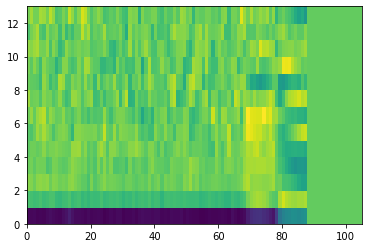

In [131]:
plt.pcolormesh(data[14])

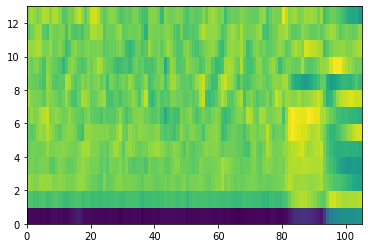

In [132]:
plt.pcolormesh(data2[14])

In [9]:
# MODEL (adapted from there: https://www.kaggle.com/code/talmanr/cnn-with-pytorch-using-mel-features/notebook)
class CnnAudioNet(nn.Module):
    def __init__(self,NumClasses):
        super(CnnAudioNet,self).__init__()
        self.NumClasses = NumClasses
        self.Fc_features = 128
        self.C1 = nn.Conv2d(1,32,3,padding=1)
        self.C2 = nn.Conv2d(32,32,5,padding=1)
        self.BN1 = nn.BatchNorm2d(32)  # change size of batch norm?
        self.fc1 = nn.Linear(1536,128)
        self.fc2 = nn.Linear(128, self.NumClasses)
        self.maxpool1 = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        
        self.C3 = nn.Conv2d(32,64,5,padding=1)
        self.BN2 = nn.BatchNorm2d(64)


    def forward(self,x):        
        x = F.relu(self.BN1(self.C1(x)))
        x = self.maxpool1(F.relu(self.BN1(self.C2(x))))
        
        x = self.maxpool1(F.relu(self.BN2(self.C3(x))))
                
        x = (x.view(-1,np.prod(x.shape[1:]))) # self.dropout
        # dim to know here for fully connected
        # print(x.shape)
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        return x

labels = sorted(list(set(datapoint[2] for datapoint in train_set)))  

model = CnnAudioNet(len(labels))
model.to(device)  # convert initialized model to CUDA optimized model
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

  0%|          | 0/20 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

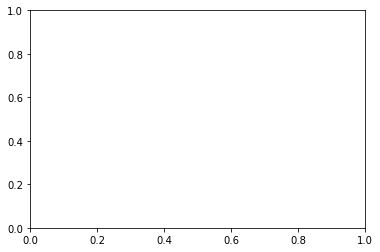

In [11]:
# run first with - F.nll_loss 10 iterations, than +F.nll_loss 20 iterations, it works starts to have results, lr 1e-3
model.train()

train_loss_history, nb_epochs = [], 20
valid_loss_history = []
for epoch in tqdm(range(nb_epochs)):
    # train and eval train loss
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        plt.pcolormesh(data);
        target = target.to(device)
        data = (data-data.mean())/data.std()
        data = data.to(device, dtype=torch.float)
        output = model(data.unsqueeze(1)) #bug
        _, pred = torch.max(output,1)

        # negative log-likelihood for tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output, target)

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()

        train_loss += loss.item()
    print('Train batch loss: {:.6f},'.format(train_loss))
    train_loss_history.append(loss)
    
#     # eval val loss
#     with torch.no_grad():
#         model.eval()
#         valid_loss = 0 
#         for data, target in validation_loader:
            
#             target = target.to(device)
#             data = data.to(device, dtype=torch.float)
#             output = model(data.unsqueeze(1))
#             _,pred = torch.max(output,1)
            
#             loss = F.nll_loss(output, target)
#             valid_loss += loss.item()
#     valid_loss_history.append(valid_loss)
            
            

    
plt.plot(train_loss_history, "r--", label="train_loss")
# plt.plot(valid_loss_history, "g--", label="val_loss")
plt.legend();

In [ ]:
pred

In [ ]:
target

In [ ]:
from preprocessing import Preprocessing  # run first with - F.nll_loss 10 iterations, than +F.nll_loss 20 iterations, it works starts to have results, lr 1e-3



processor = Preprocessing(train_set, validation_set, test_set)
model.train()

train_loss_history, nb_epochs = [], 20
valid_loss_history = []
for epoch in tqdm(range(nb_epochs)):
    
    # train and eval train loss
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):

        print(target)
        target = target.to(device)
        data = (data-data.mean())/data.std()

        data = data.to(device, dtype=torch.float)
        output = model(data.unsqueeze(1))
        _, pred = torch.max(output,1)

        # negative log-likelihood for tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output, target)

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()

        train_loss += loss.item()
    print('Train batch loss: {:.6f},'.format(train_loss))
    train_loss_history.append(loss)
    
#     # eval val loss
#     with torch.no_grad():
#         model.eval()
#         valid_loss = 0 
#         for data, target in validation_loader:
            
#             target = target.to(device)
#             data = data.to(device, dtype=torch.float)
#             output = model(data.unsqueeze(1))
#             _,pred = torch.max(output,1)
            
#             loss = F.nll_loss(output, target)
#             valid_loss += loss.item()
#     valid_loss_history.append(valid_loss)
            
            

    
plt.plot(train_loss_history, "r--", label="train_loss")
# plt.plot(valid_loss_history, "g--", label="val_loss")
plt.legend();

In [ ]:
np.max(train_set[100][0])